In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d
from datetime import datetime, timedelta
import statsmodels.api as sm
import datetime
from sklearn import linear_model
from itertools import product
import warnings
import statsmodels.api as sm

# 1 Выберите одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок. Не используйте данные за последний имеющийся месяц — июнь 2016! Создайте регрессионные признаки для учёта сезонностей и трендов.

Возьмем зону номер 1223, содержащую перекресток Atlantic Avenue и 3rd Avenue. Это 25й квадрат слева и 23й снизу на карте.

In [2]:
zone = 1223

In [3]:
# Файлы данных за 2 года - с июня 2014 по май 2016.
# К сожалению, ARIMA на таком количестве данных просто виснет. поэтому берем минимально разрешенное - 3 месяца.
filenames = [
#             'D:\\project\\yellow_tripdata_2014-06.csv',
#             'D:\\project\\yellow_tripdata_2014-07.csv',
#             'D:\\project\\yellow_tripdata_2014-08.csv',
#             'D:\\project\\yellow_tripdata_2014-09.csv',
#             'D:\\project\\yellow_tripdata_2014-10.csv',
#             'D:\\project\\yellow_tripdata_2014-11.csv',
#             'D:\\project\\yellow_tripdata_2014-12.csv',
#             'D:\\project\\yellow_tripdata_2015-01.csv',
#             'D:\\project\\yellow_tripdata_2015-02.csv',
#             'D:\\project\\yellow_tripdata_2015-03.csv',
#             'D:\\project\\yellow_tripdata_2015-04.csv',
#             'D:\\project\\yellow_tripdata_2015-05.csv',
#             'D:\\project\\yellow_tripdata_2015-06.csv',
#             'D:\\project\\yellow_tripdata_2015-07.csv',
#             'D:\\project\\yellow_tripdata_2015-08.csv',
#             'D:\\project\\yellow_tripdata_2015-09.csv',
#             'D:\\project\\yellow_tripdata_2015-10.csv',
#             'D:\\project\\yellow_tripdata_2015-11.csv',
#             'D:\\project\\yellow_tripdata_2015-12.csv',
#             'D:\\project\\yellow_tripdata_2016-01.csv',
#             'D:\\project\\yellow_tripdata_2016-02.csv',
             'D:\\project\\yellow_tripdata_2016-03.csv',
             'D:\\project\\yellow_tripdata_2016-04.csv',
             'D:\\project\\yellow_tripdata_2016-05.csv']
regions_filename = 'D:\\project\\regions.csv'

In [4]:
# Типы данных, которые будем использовать при загрузке файлов для экономии памяти:
# В старых файлах данные отличаются, поэтому не сможем использовать все
data_types = {#'VendorID' :np.int8,
                #'tpep_pickup_datetime'
                #'tpep_dropoff_datetime'
                #'passenger_count':np.int8,
                'trip_distance': np.float32 , 
                'pickup_longitude': np.float32 , 
                'pickup_latitude': np.float32 , 
                'RatecodeID':np.int8,
                #'store_and_fwd_flag'
                'dropoff_longitude': np.float32 , 
                'dropoff_latitude': np.float32 , 
                #'payment_type':np.int8,
                'fare_amount': np.float32 , 
                'extra': np.float32 , 
                'mta_tax': np.float32 , 
                'tip_amount': np.float32 , 
                'tolls_amount': np.float32 , 
                'improvement_surcharge': np.float32 , 
                'total_amount': np.float32}

In [5]:
# функция для применения правил фильтрации

def predobrabotka(df):
    
    
    
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], yearfirst = True,format='%Y-%m-%d %H')
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], yearfirst = True,format='%Y-%m-%d %H')
    # в старых файлах вместо tpep_pickup_datetime и tpep_dropoff_datetime просто pickup_datetime, dropoff_datetime
    
    
    NY = np.array([[-74.25559, -73.70001], [40.49612, 40.91553]])
    
    df = df.reset_index(drop=True)
       
    
    df['duration_trip'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.seconds


    df = df[df['duration_trip'] > 0]
    df.drop('duration_trip',axis=1, inplace=True)
    
    df = df[df['passenger_count'] != 0]
    
    df = df[df['trip_distance'] != 0]
    
    df = df[(NY[0][0] <= df['pickup_longitude']) & (df['pickup_longitude'] <= NY[0][1]) & 
            (NY[1][0] <= df['pickup_latitude']) & (df['pickup_latitude'] <= NY[1][1])]
        
    df['tpep_pickup_datetime'] = df['tpep_pickup_datetime'].dt.floor('h')
    df['tpep_dropoff_datetime'] = df['tpep_dropoff_datetime'].dt.floor('h')
    
    df = df.reset_index(drop=True)
    return df

In [6]:
# координаты зон:
given_regions = pd.read_csv(regions_filename, sep=';', header=0)
print given_regions.head()
print given_regions.info()

   region      west       east      south      north
0       1 -74.25559 -74.244478  40.496120  40.504508
1       2 -74.25559 -74.244478  40.504508  40.512896
2       3 -74.25559 -74.244478  40.512896  40.521285
3       4 -74.25559 -74.244478  40.521285  40.529673
4       5 -74.25559 -74.244478  40.529673  40.538061
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 5 columns):
region    2500 non-null int64
west      2500 non-null float64
east      2500 non-null float64
south     2500 non-null float64
north     2500 non-null float64
dtypes: float64(4), int64(1)
memory usage: 97.7 KB
None


In [7]:
aggregated = binned_statistic_2d((given_regions['west'].values), (given_regions['south'].values),
                                 None, 'count', 
                                 expand_binnumbers=True, 
                                 bins=[np.sort(np.unique(np.append(given_regions['west'].values, given_regions['east'].values[-1]))),
                                       np.sort(np.unique(np.append(given_regions['south'].values, given_regions['north'].values[-1])))
                                      ])
coord=dict() # Словарь с соответствием номера зоны его порядковым номерам в матрице бинов
for i in range(given_regions.shape[0]):
    coord[(aggregated.binnumber[0][i], aggregated.binnumber[1][i])] = given_regions.region[i]
print coord[(25,23)]

1223


In [8]:
def bin_statistics_to_list(array2d): # линеаризация вывода binned_statistic_2d 
                                    #в нужный нам список по 2500 зонам:
        output = np.zeros(array2d.shape[0]*array2d.shape[1])
        for i in range(array2d.shape[0]):
            for j in range(array2d.shape[1]):
                output[coord[(i+1,j+1)] - 1] = array2d[i][j]
        return output
    

In [9]:
# агрегация данных
def aggregate_time_zones_month(df, month = 5, year = 2016):
       
    a = datetime.datetime(year, month, 1)
    b = timedelta(hours=1, minutes=0, seconds=0)
    
    timelist = list()
    zonelist = list()

    
    we_values = np.sort(np.unique(np.append(given_regions['west'].values, given_regions['east'].values[-1])))
    sn_values =np.sort(np.unique(np.append(given_regions['south'].values, given_regions['north'].values[-1]))) 
    
    while a.month == month:
        
        timelist=timelist + [a]
        a = a + b
        
    
    frame1 = pd.DataFrame(columns=['zone'] + timelist)
    frame1.zone = range(1,2501)
    frame1[timelist] = np.zeros((frame1.shape[0], len(timelist)))
    frame1 =frame1.set_index('zone')
    
    
    
    l = df.shape[0] # проверяем датафрейм на пустоту
    if l == 0:
        return None

    
    timelist = np.unique(df['tpep_pickup_datetime'])
    
    timelist = timelist.astype('M8[ms]').astype('O') # Перевод из np.datetime64 в datetime.datetime
    
    
    for i in timelist:
        
        
        df1 = df[df['tpep_pickup_datetime'] == i]
            
        aggregate = binned_statistic_2d(df1['pickup_longitude'].values, df1['pickup_latitude'].values,
                                 None, 'count', 
                                 expand_binnumbers=True, 
                                 bins=[we_values, sn_values])
        
        frame1[i] = frame1[i] + bin_statistics_to_list(aggregate.statistic)
    
   
    return   frame1

In [10]:
def get_date_from_filename(probe): # Узнаем из имени файла, к какому месяцу и году он относится
    probe = probe.split('_')
    probe = probe[len(probe) - 1]
    probe = probe.split('.')
    probe = probe[len(probe) - 2]
    probe = probe.split('-')
    year = probe[0]; month = probe[1]
    return int(year), int(month)

In [11]:
def aggregate_one_zone(filelist, zone_num):
    
    i=0
    
    # В старых версиях файлов кроме запятых между данными вставлены еще и пробелы. 
    # Причем только в заголовке. Будем ставить принудительно заголовки из поздних версий.
    
    probe = pd.read_csv('D:\\project\\yellow_tripdata_2016-05.csv', nrows=0, sep=',', dtype=data_types, header=0)
    
    
    chunksize = 7 * 10 ** 5
    for filename in filelist:
        columns = list(probe.columns)
        if pd.read_csv(filename, nrows=0).shape[1] == 18:
               columns.remove('improvement_surcharge')
        
        raw_data = pd.read_csv(filename, nrows=0, names=columns ,header=0 , dtype=data_types)
        #print raw_data.head()
        #print columns
        raw_data = predobrabotka(raw_data)
        
        for chunk in pd.read_csv(filename, chunksize=chunksize, header=0 ,iterator=True,names=columns, dtype=data_types):
            data1 = predobrabotka(chunk)
            raw_data = pd.concat([raw_data, data1], ignore_index=True)
        
        
        year, month = get_date_from_filename(filename)
        
        aggregate = aggregate_time_zones_month(raw_data, month = month, year = year)
        
        aggregate = aggregate.loc[zone_num] # выбираем строку по только одной зоне
        
        
        
        if i==0:
            aggregate_one_zone = aggregate
            i = 1
            
        else:
            aggregate_one_zone = pd.concat([aggregate_one_zone, aggregate], axis=1)
        
        print filename + ' complete'
    aggregate_one_zone = aggregate_one_zone.transpose()
    
    return aggregate_one_zone

In [ ]:
%%time
raw_data = aggregate_one_zone(filenames, zone)

In [12]:
#raw_data = raw_data.transpose()
print raw_data.info()
print raw_data.head()

NameError: name 'raw_data' is not defined

In [34]:
# Сохраним в файл, чтобы не повторять  это все в случае крэша:
raw_data.to_csv('D:\\project\\zone_1223_3m.csv', header=True, index=True)

In [12]:
raw_data =pd.read_csv('D:\\project\\zone_1223_3m.csv',header=0, index_col=False) # загружаем из файла
print raw_data.head()

   Unnamed: 0  2016-03-01 00:00:00  2016-03-01 01:00:00  2016-03-01 02:00:00  \
0        1223                 16.0                 15.0                  7.0   
1        1223                  NaN                  NaN                  NaN   
2        1223                  NaN                  NaN                  NaN   

   2016-03-01 03:00:00  2016-03-01 04:00:00  2016-03-01 05:00:00  \
0                  9.0                 10.0                 11.0   
1                  NaN                  NaN                  NaN   
2                  NaN                  NaN                  NaN   

   2016-03-01 06:00:00  2016-03-01 07:00:00  2016-03-01 08:00:00  \
0                 15.0                 22.0                 12.0   
1                  NaN                  NaN                  NaN   
2                  NaN                  NaN                  NaN   

          ...           2016-05-31 14:00:00  2016-05-31 15:00:00  \
0         ...                           NaN                  NaN 

In [13]:
# concat нам создавал почему-то новую строку/столбец вместо присоединения, как победить, не нашел. 
# Ручками преобразуем в один столбец через  использование Series:

raw_data1 = raw_data.reset_index(drop=True)
raw_data2 = raw_data1.loc[0].dropna()
for i in range(raw_data1.shape[0]-1):
    raw_data3 = raw_data1.loc[i+1].dropna()
    raw_data2 = pd.concat([raw_data2,raw_data3])
raw_data2 = pd.DataFrame(raw_data2)
raw_data2 = raw_data2.drop(['Unnamed: 0'],axis=0)
raw_data2['index'] = pd.to_datetime(raw_data2.index.values)
raw_data2 = raw_data2.reset_index(drop=True)
raw_data2 = raw_data2.set_index('index')
print raw_data2.columns
print raw_data2.info()
print raw_data2.head()

Index([0], dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2208 entries, 2016-03-01 00:00:00 to 2016-05-31 23:00:00
Data columns (total 1 columns):
0    2208 non-null float64
dtypes: float64(1)
memory usage: 34.5 KB
None
                        0
index                    
2016-03-01 00:00:00  16.0
2016-03-01 01:00:00  15.0
2016-03-01 02:00:00   7.0
2016-03-01 03:00:00   9.0
2016-03-01 04:00:00  10.0


In [14]:
raw_data = raw_data2.copy()
print raw_data

                        0
index                    
2016-03-01 00:00:00  16.0
2016-03-01 01:00:00  15.0
2016-03-01 02:00:00   7.0
2016-03-01 03:00:00   9.0
2016-03-01 04:00:00  10.0
2016-03-01 05:00:00  11.0
2016-03-01 06:00:00  15.0
2016-03-01 07:00:00  22.0
2016-03-01 08:00:00  12.0
2016-03-01 09:00:00  13.0
2016-03-01 10:00:00   5.0
2016-03-01 11:00:00   5.0
2016-03-01 12:00:00  10.0
2016-03-01 13:00:00   6.0
2016-03-01 14:00:00   9.0
2016-03-01 15:00:00   4.0
2016-03-01 16:00:00  12.0
2016-03-01 17:00:00  15.0
2016-03-01 18:00:00  16.0
2016-03-01 19:00:00  24.0
2016-03-01 20:00:00  16.0
2016-03-01 21:00:00  25.0
2016-03-01 22:00:00  27.0
2016-03-01 23:00:00  15.0
2016-03-02 00:00:00  15.0
2016-03-02 01:00:00  11.0
2016-03-02 02:00:00   5.0
2016-03-02 03:00:00   5.0
2016-03-02 04:00:00   6.0
2016-03-02 05:00:00   4.0
...                   ...
2016-05-30 18:00:00  14.0
2016-05-30 19:00:00  12.0
2016-05-30 20:00:00  16.0
2016-05-30 21:00:00  13.0
2016-05-30 22:00:00   5.0
2016-05-30 2

In [15]:
del raw_data1, raw_data2, raw_data3

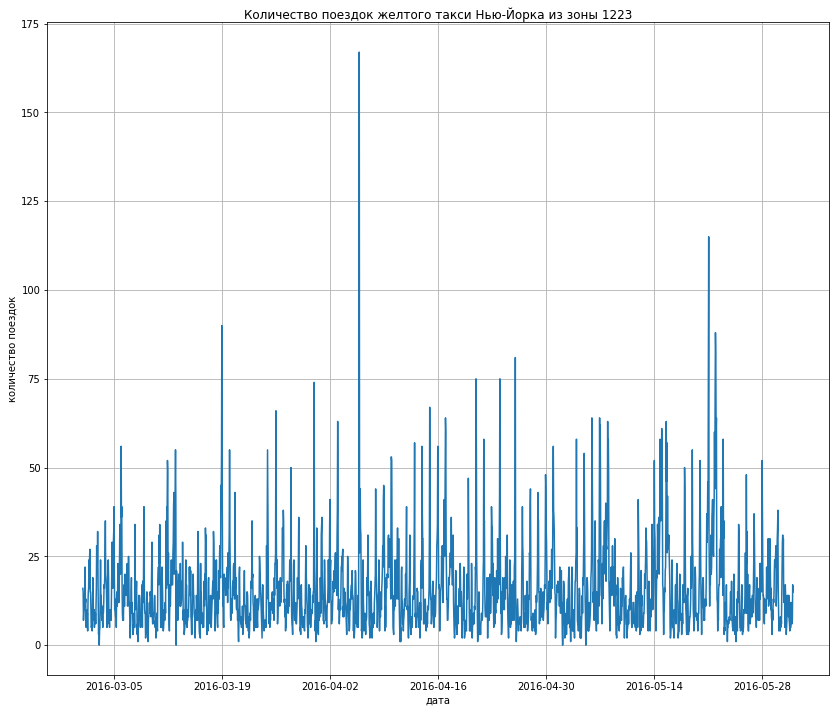

In [16]:
# Посмотрим на внешний вид получившихся данных:
plt.figure(figsize=(14,12))
plt.grid(True)
plt.title(u'Количество поездок желтого такси Нью-Йорка из зоны 1223')
plt.xlabel(u'дата')
plt.ylabel(u'количество поездок')
plt.plot(raw_data.index , raw_data[0].values);

Видны недельные гармоники. Посмотрим за месяц:

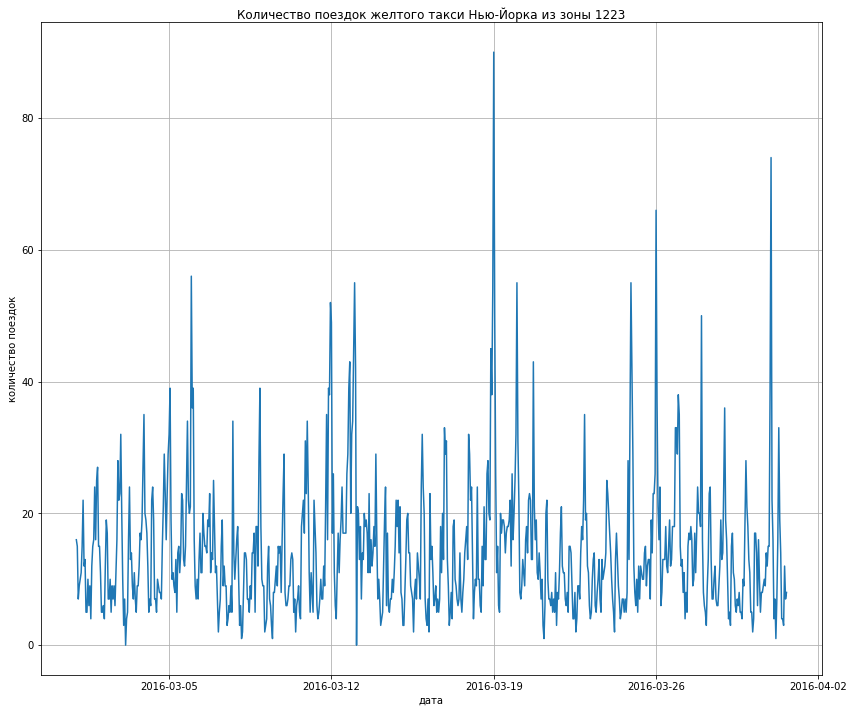

In [17]:
plt.figure(figsize=(14,12))
plt.grid(True)
plt.title(u'Количество поездок желтого такси Нью-Йорка из зоны 1223')
plt.xlabel(u'дата')
plt.ylabel(u'количество поездок')
plt.plot(raw_data[0].head(int(round(raw_data.shape[0] / 3))).index , raw_data[0].head(int(round(raw_data.shape[0] / 3))).values);

Посмотрим данные за неделю с лишним:

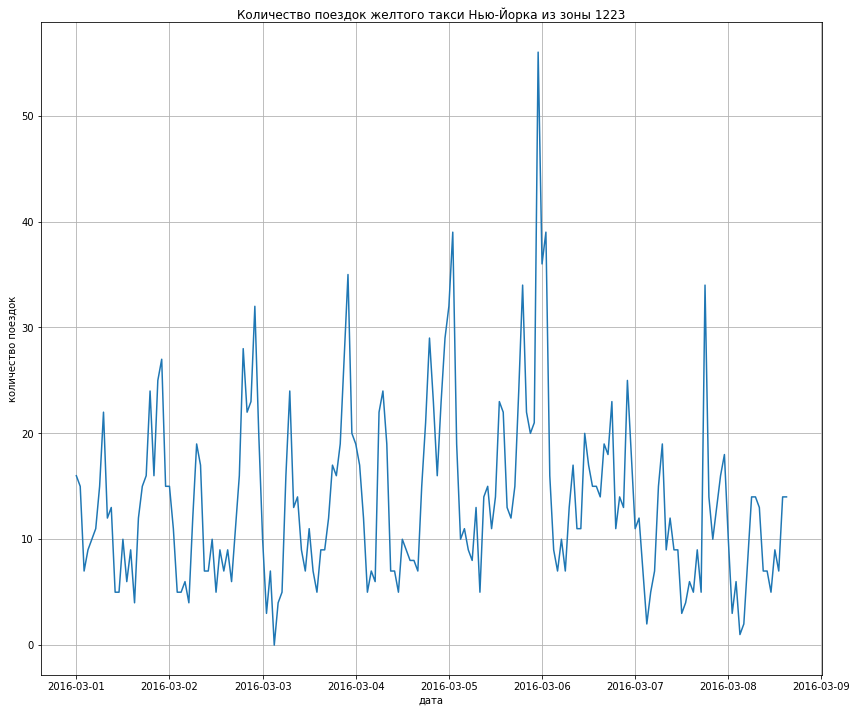

In [18]:
plt.figure(figsize=(14,12))
plt.grid(True)
plt.title(u'Количество поездок желтого такси Нью-Йорка из зоны 1223')
plt.xlabel(u'дата')
plt.ylabel(u'количество поездок')
plt.plot(raw_data[0].head(int(round(raw_data.shape[0] / 12))).index , raw_data[0].head(int(round(raw_data.shape[0] / 12))).values);

Здесь уже угадываются суточные колебания. Посмотрим за сутки:

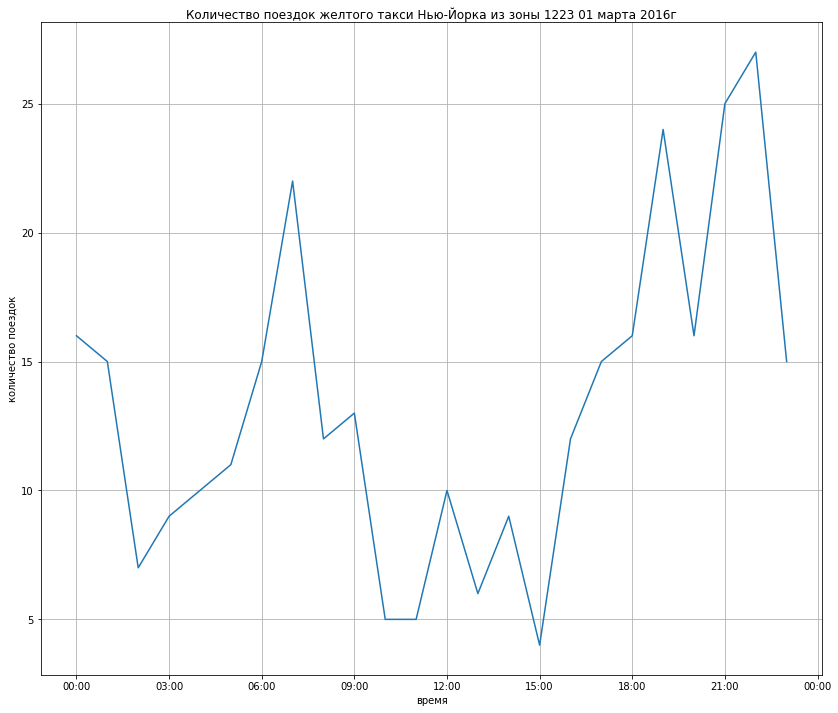

In [19]:
plt.figure(figsize=(14,12))
plt.grid(True)
plt.title(u'Количество поездок желтого такси Нью-Йорка из зоны 1223 01 марта 2016г')
plt.xlabel(u'время')
plt.ylabel(u'количество поездок')
plt.plot(raw_data[0].head(24).index , raw_data[0].head(24).values);

Спад с утра до обеда и повышение в обед и к вечеру.

Применим STL-декомпозицию ряда:
    

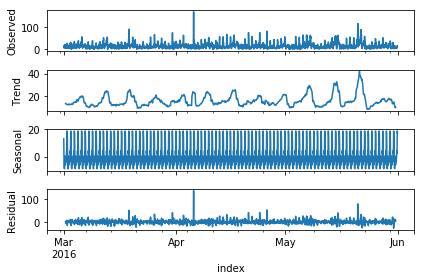

In [20]:
sm.tsa.seasonal_decompose(raw_data[0]).plot();

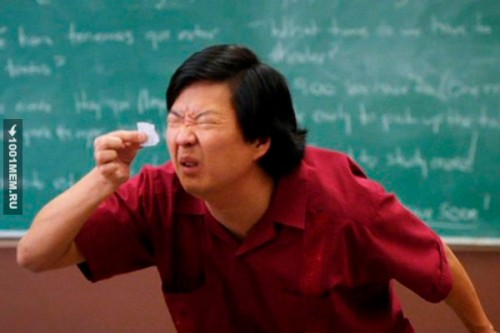

In [21]:
from IPython.display import Image
url='https://www.meme-arsenal.com/memes/d1e063d874347c97bda33f7ea754aa88.jpg'
Image(url) 

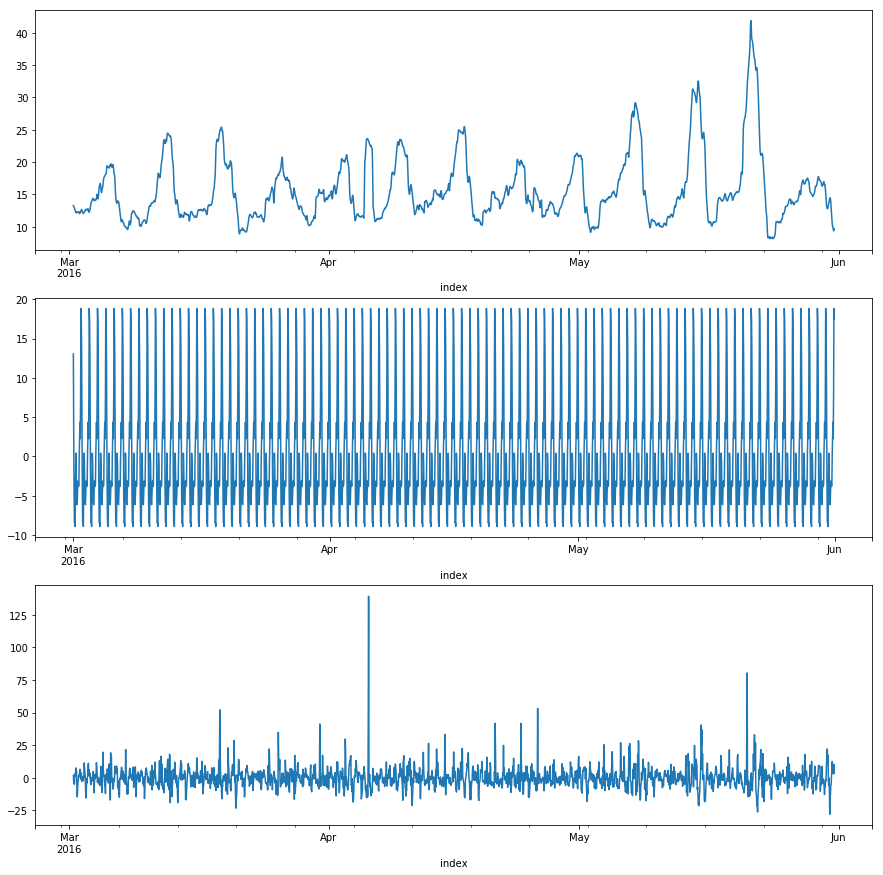

In [22]:
res = sm.tsa.seasonal_decompose(raw_data[0])
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,15))
res.trend.plot(ax=ax1)
res.seasonal.plot(ax=ax2)
res.resid.plot(ax=ax3);

Видим:

    -Очень слабый повышающийся тренд;
    -Небольшое повышение дисперсии.

Итак, для дисперсии возьмем признаки: 
    
    -Выходные и празничные дни;
    -Гармоники по неделям;
    -Гармоники внутри суток.

# 2 Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.

Гармоники по неделям мы учтем согласно функциям в задании.

Нужно учесть праздники

Ежегодные выходные праздничные дни, установленные федеральным правительством США:

    Новый год – 1 января
    День Мартина Лютера Кинга – 3-й понедельник января
    День рождения Джорджа Вашингтона – 3-й понедельник февраля
    День поминовения – последний понедельник мая
    День независимости – 4 июля
    День труда – 1-й понедельник сентября
    День Колумба – 2-й понедельник октября
    День ветеранов – 11 ноября
    День благодарения – 4-й четверг ноября
    Рождество – 25 декабря

In [23]:
# Функция, составляющая список праздничных дней на указанные годы
def holidays(years):
    output = list()
    for year in years:
        
        # Новый Год:
        New_year = datetime.date(year, 1, 1)
        output.append(New_year)
        
        # День Мартина Лютера Кинга:
        Jan_1 = datetime.date(year, 1, 1).isoweekday() # День недели 1 января
        if Jan_1 == 1: # Если это уже понедельник:
            MLK = 1 + 21
        else: # Если это уже другой день недели:
            MLK = (7 - Jan_1) + 14 + 1 + 1 
        MLK = datetime.date(year, 1, MLK)
        output.append(MLK)
        
        # День рождения Джорджа Вашингтона:
        Feb_1 = datetime.date(year, 2, 1).isoweekday() # День недели 2 февраля
        if Feb_1 == 1: # Если это уже понедельник:
            JW = 1 + 21
        else: # Если это уже другой день недели:
            JW = (7 - Feb_1) + 14 + 1 + 1 
        JW = datetime.date(year, 2, JW)
        output.append(JW)
        
        # День поминовения:
        May_31 = datetime.date(year, 5, 31).isoweekday()
        if May_31 == 1: # Если это уже понедельник:
            Memory = 31
        else: # Если это уже другой день недели:
            Memory = 31 - May_31 + 1
        Memory = datetime.date(year, 5, Memory)
        output.append(Memory)
        
        # День независимости:
        Indep = datetime.date(year, 7, 4)
        output.append(Indep)
        
        # День труда:
        Sep_1 = datetime.date(year, 9, 1).isoweekday()
        if Sep_1 == 1: # Если это уже понедельник:
            Work = 1
        else: # Если это уже другой день недели:
            Work = (7 - Sep_1) + 1 + 1 
        Work = datetime.date(year, 9, Work)
        output.append(Work)
        
        #День Колумба:
        Oct_1 = datetime.date(year, 10, 1).isoweekday()
        if Oct_1 == 1: # Если это уже понедельник:
            Columbus = 1
        else: # Если это уже другой день недели:
            Columbus = (7 - Oct_1) + 7 + 1 + 1 
        Columbus = datetime.date(year, 10, Columbus)
        output.append(Columbus)
        
        # День ветеранов:
        Veterans = datetime.date(year, 11, 11)
        output.append(Veterans)
        
        # День благодарения:
        Nov_1 = datetime.date(year, 11, 1).isoweekday()
        if Nov_1 == 1: # Если это уже понедельник:
            Thanksgiving = 1 + 28
        else: # Если это уже другой день недели:
            Thanksgiving = (7 - Nov_1) + 21 + 1 + 1 
        Thanksgiving = datetime.date(year, 10, Thanksgiving)
        output.append(Thanksgiving)
        
        # Рождество: (Добавим сюда же даты до 31 декабря - на графике видно, что там такой же спад)
        for day in range(25, 32, 1):
            Christmas = datetime.date(year, 12, day)
            output.append(Christmas)
        
    return output


In [24]:
print holidays([2016]) # Проверим на 2014 году

[datetime.date(2016, 1, 1), datetime.date(2016, 1, 18), datetime.date(2016, 2, 22), datetime.date(2016, 5, 30), datetime.date(2016, 7, 4), datetime.date(2016, 9, 5), datetime.date(2016, 10, 10), datetime.date(2016, 11, 11), datetime.date(2016, 10, 28), datetime.date(2016, 12, 25), datetime.date(2016, 12, 26), datetime.date(2016, 12, 27), datetime.date(2016, 12, 28), datetime.date(2016, 12, 29), datetime.date(2016, 12, 30), datetime.date(2016, 12, 31)]


In [25]:
# Теперь нам нужна функция, которая из отсортированного 
# списка datetime возвращает список годов, в нем присутствующих:

def get_years(datetimes):
    year1 = datetimes[0].year
    year2 = datetimes[len(datetimes)-1].year
    output = range(year1, year2 + 1, 1)
    return  output


In [26]:
print get_years(raw_data.index)

[2016]


In [27]:
# Функция, сравнивающая datetime со списком праздников и возвращающая флаги
# 0 (False) если не праздник и 1 (True) если праздник

def define_holidays(datetimes):
    years = get_years(datetimes)
    holiday_list = holidays(years)
    output = np.zeros(len(datetimes))
    
    for i in range(len(datetimes)):
        if datetimes[i].date() in holiday_list:
            output[i] = 1
    return output
        

In [28]:
raw_data['holiday'] = define_holidays(raw_data.index).astype(bool)
print raw_data.head()

                        0  holiday
index                             
2016-03-01 00:00:00  16.0    False
2016-03-01 01:00:00  15.0    False
2016-03-01 02:00:00   7.0    False
2016-03-01 03:00:00   9.0    False
2016-03-01 04:00:00  10.0    False


In [29]:
# Проверим День поминовения - 30 мая 2016
print raw_data.loc['2016-05-30 00:00:00', 'holiday']

True


Регрессионные признаки для учета сезонностей и трендов:

$s_i = \sin \left( [1,\dots,T] * 2 \pi i/ 168 \right), $

$c_i = \cos \left( [1,\dots,T] * 2 \pi i/ 168 \right), $

$i=1,\dots, K.$

Здесь $T$— это длина моделируемого ряда в часах, 168 — длительность недели в часах, а значение параметра K предстоит подобрать самостоятельно (в зависимости от длины подготовленного ряда, можно для начала взять $K$ равным 2-5).

In [30]:
# Определим функцию, возвращающую si и ci при заданной длине ряда и k
def ci_si(data, k):
    T = len(data)
    arg = range(1, T + 1)
    arg = np.array(arg)
    columns = list()
    
    for i in range(1, k + 1):
        columns.append('s' + str(i))
        columns.append('c' + str(i))
    output = pd.DataFrame(columns=columns)
    
    for i in range(1, k + 1):
        output['s'+ str(i)] = np.sin(arg * 2 * np.pi * i / 168)
        output['c'+ str(i)] = np.cos(arg * 2 * np.pi * i / 168)
        
    return output

In [31]:
# Возьмем k=5
data5 = ci_si(raw_data[0], 5)
print data5.head()
print data5.shape

         s1        c1        s2        c2        s3        c3        s4  \
0  0.037391  0.999301  0.074730  0.997204  0.111964  0.993712  0.149042   
1  0.074730  0.997204  0.149042  0.988831  0.222521  0.974928  0.294755   
2  0.111964  0.993712  0.222521  0.974928  0.330279  0.943883  0.433884   
3  0.149042  0.988831  0.294755  0.955573  0.433884  0.900969  0.563320   
4  0.185912  0.982566  0.365341  0.930874  0.532032  0.846724  0.680173   

         c4        s5        c5  
0  0.988831  0.185912  0.982566  
1  0.955573  0.365341  0.930874  
2  0.900969  0.532032  0.846724  
3  0.826239  0.680173  0.733052  
4  0.733052  0.804598  0.593820  
(2208, 10)


In [32]:
data5= pd.concat([data5, pd.Series(raw_data.holiday.values)], axis=1, ignore_index=True)
print data5.head()
print data5.shape

         0         1         2         3         4         5         6   \
0  0.037391  0.999301  0.074730  0.997204  0.111964  0.993712  0.149042   
1  0.074730  0.997204  0.149042  0.988831  0.222521  0.974928  0.294755   
2  0.111964  0.993712  0.222521  0.974928  0.330279  0.943883  0.433884   
3  0.149042  0.988831  0.294755  0.955573  0.433884  0.900969  0.563320   
4  0.185912  0.982566  0.365341  0.930874  0.532032  0.846724  0.680173   

         7         8         9      10  
0  0.988831  0.185912  0.982566  False  
1  0.955573  0.365341  0.930874  False  
2  0.900969  0.532032  0.846724  False  
3  0.826239  0.680173  0.733052  False  
4  0.733052  0.804598  0.593820  False  
(2208, 11)


In [33]:
data = data5.copy()
labels = raw_data[0]

In [34]:
# Обучим регрессию

regression = linear_model.LinearRegression()
regression.fit(data,labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [35]:
# Получим предсказание с коэффициентами , выбранными регрессией
data5['predictions'] = regression.predict(data)

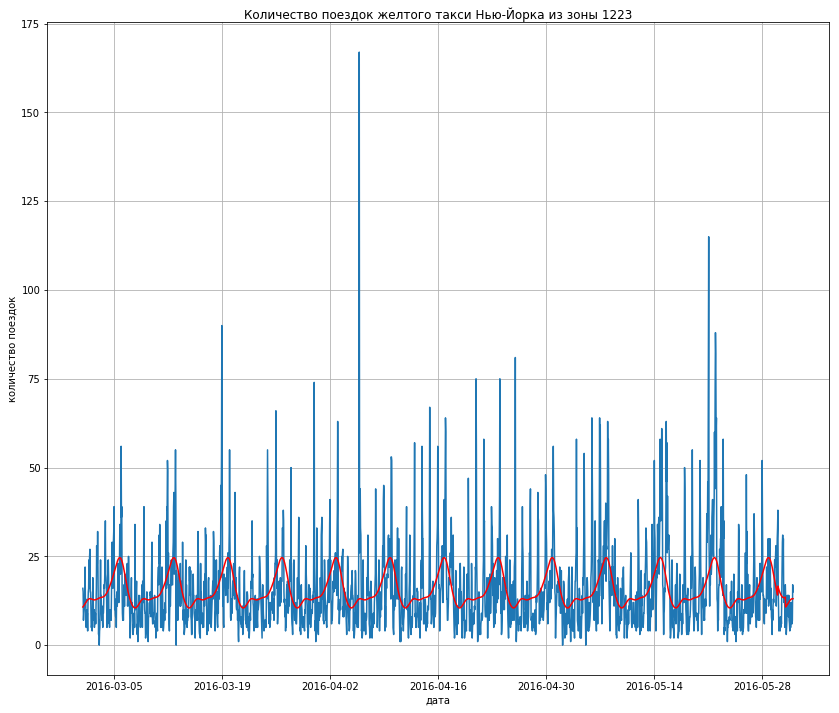

In [36]:
# Посмотрим на графики за 3 месяца

plt.figure(figsize=(14,12))
plt.grid(True)
plt.title(u'Количество поездок желтого такси Нью-Йорка из зоны 1223')
plt.xlabel(u'дата')
plt.ylabel(u'количество поездок')
plt.plot(raw_data[0].head(int(round(raw_data.shape[0]))).index , raw_data[0].head(int(round(raw_data.shape[0]))).values)
plt.plot(raw_data[0].head(int(round(raw_data.shape[0]))).index , data5['predictions'].head(int(round(raw_data.shape[0]))).values, color='r');

Видим, что общие тенденции угаданы, но гармоник мало. Попробуем включить больше.

In [110]:
# k=10
data10 = ci_si(raw_data[0], 10)
print data10.head()
print data10.shape

         s1        c1        s2        c2        s3        c3        s4  \
0  0.037391  0.999301  0.074730  0.997204  0.111964  0.993712  0.149042   
1  0.074730  0.997204  0.149042  0.988831  0.222521  0.974928  0.294755   
2  0.111964  0.993712  0.222521  0.974928  0.330279  0.943883  0.433884   
3  0.149042  0.988831  0.294755  0.955573  0.433884  0.900969  0.563320   
4  0.185912  0.982566  0.365341  0.930874  0.532032  0.846724  0.680173   

         c4        s5        c5        s6        c6        s7        c7  \
0  0.988831  0.185912  0.982566  0.222521  0.974928  0.258819  0.965926   
1  0.955573  0.365341  0.930874  0.433884  0.900969  0.500000  0.866025   
2  0.900969  0.532032  0.846724  0.623490  0.781831  0.707107  0.707107   
3  0.826239  0.680173  0.733052  0.781831  0.623490  0.866025  0.500000   
4  0.733052  0.804598  0.593820  0.900969  0.433884  0.965926  0.258819   

         s8        c8        s9        c9       s10       c10  
0  0.294755  0.955573  0.330279  0

In [111]:
data10= pd.concat([data10, pd.Series(raw_data.holiday.values)], axis=1, ignore_index=True)
print data10.head()
print data10.shape

         0         1         2         3         4         5         6   \
0  0.037391  0.999301  0.074730  0.997204  0.111964  0.993712  0.149042   
1  0.074730  0.997204  0.149042  0.988831  0.222521  0.974928  0.294755   
2  0.111964  0.993712  0.222521  0.974928  0.330279  0.943883  0.433884   
3  0.149042  0.988831  0.294755  0.955573  0.433884  0.900969  0.563320   
4  0.185912  0.982566  0.365341  0.930874  0.532032  0.846724  0.680173   

         7         8         9   ...          11        12        13  \
0  0.988831  0.185912  0.982566  ...    0.974928  0.258819  0.965926   
1  0.955573  0.365341  0.930874  ...    0.900969  0.500000  0.866025   
2  0.900969  0.532032  0.846724  ...    0.781831  0.707107  0.707107   
3  0.826239  0.680173  0.733052  ...    0.623490  0.866025  0.500000   
4  0.733052  0.804598  0.593820  ...    0.433884  0.965926  0.258819   

         14        15        16        17        18        19     20  
0  0.294755  0.955573  0.330279  0.943883  0.

In [112]:
data = data10.copy()
labels = raw_data[0]

# Обучим регрессию

regression = linear_model.LinearRegression()
regression.fit(data,labels)

# Получим предсказание с коэффициентами , выбранными регрессией
data10['predictions'] = regression.predict(data)

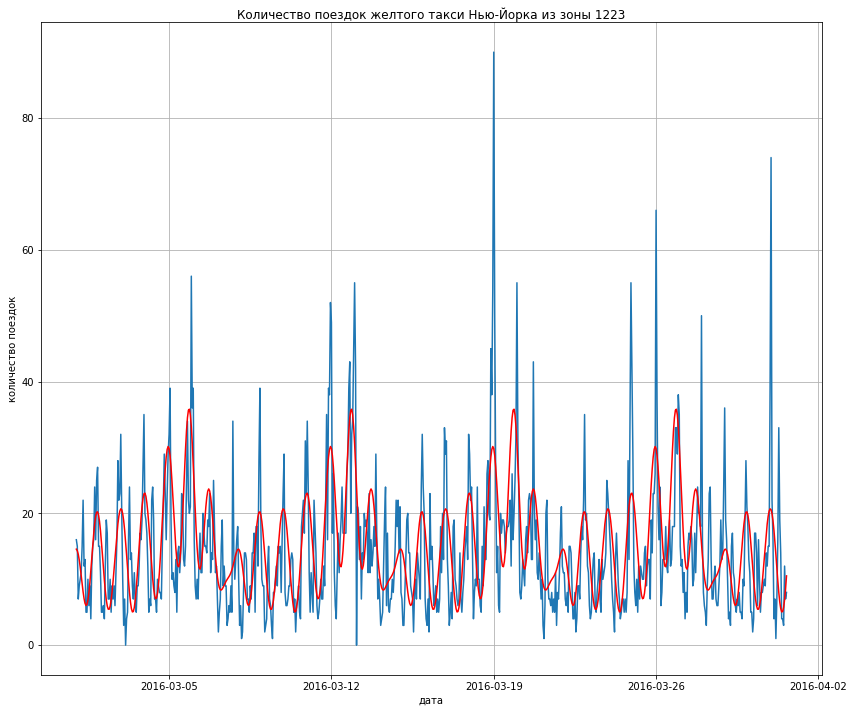

In [113]:

plt.figure(figsize=(14,12))
plt.grid(True)
plt.title(u'Количество поездок желтого такси Нью-Йорка из зоны 1223')
plt.xlabel(u'дата')
plt.ylabel(u'количество поездок')
plt.plot(raw_data[0].head(int(round(raw_data.shape[0] / 3))).index , raw_data[0].head(int(round(raw_data.shape[0] / 3))).values)
plt.plot(raw_data[0].head(int(round(raw_data.shape[0] / 3))).index , data10['predictions'].head(int(round(raw_data.shape[0] / 3))).values, color='r');

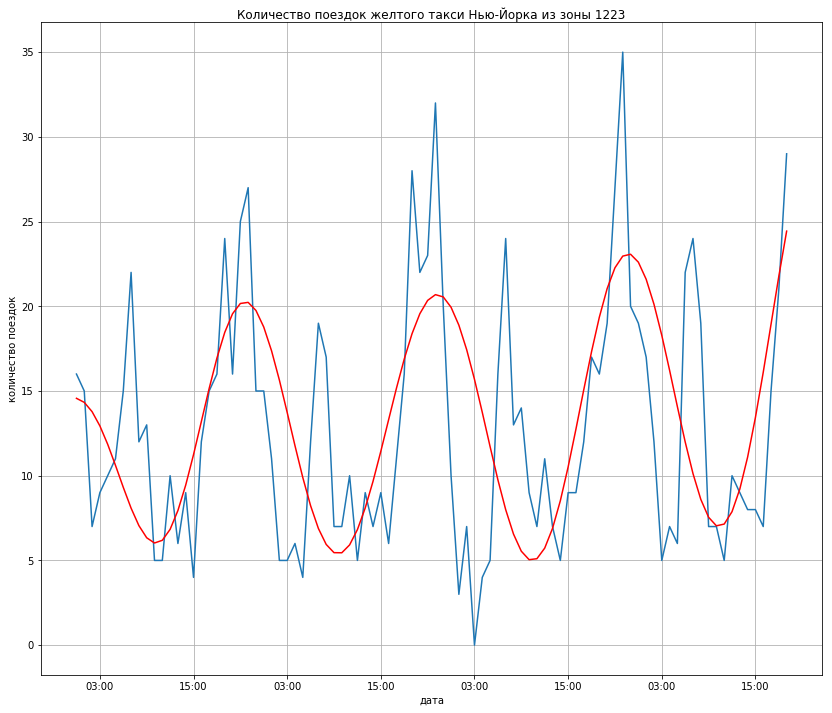

In [114]:
# Уже получше, глянем поближе:


plt.figure(figsize=(14,12))
plt.grid(True)
plt.title(u'Количество поездок желтого такси Нью-Йорка из зоны 1223')
plt.xlabel(u'дата')
plt.ylabel(u'количество поездок')
plt.plot(raw_data[0].head(int(round(raw_data.shape[0] / 24))).index , raw_data[0].head(int(round(raw_data.shape[0] / 24))).values)
plt.plot(raw_data[0].head(int(round(raw_data.shape[0] / 24))).index , data10['predictions'].head(int(round(raw_data.shape[0] / 24))).values, color='r');

Видно, что на одну гармонику регрессии приходится еще около 5 гармоник реальных данных. Добавим еще 5 признаков в регрессию:

In [115]:
data15 = ci_si(raw_data[0], 15)
print data15.head()
print data15.shape

         s1        c1        s2        c2        s3        c3        s4  \
0  0.037391  0.999301  0.074730  0.997204  0.111964  0.993712  0.149042   
1  0.074730  0.997204  0.149042  0.988831  0.222521  0.974928  0.294755   
2  0.111964  0.993712  0.222521  0.974928  0.330279  0.943883  0.433884   
3  0.149042  0.988831  0.294755  0.955573  0.433884  0.900969  0.563320   
4  0.185912  0.982566  0.365341  0.930874  0.532032  0.846724  0.680173   

         c4        s5        c5    ...          s11       c11       s12  \
0  0.988831  0.185912  0.982566    ...     0.399892  0.916562  0.433884   
1  0.955573  0.365341  0.930874    ...     0.733052  0.680173  0.781831   
2  0.900969  0.532032  0.846724    ...     0.943883  0.330279  0.974928   
3  0.826239  0.680173  0.733052    ...     0.997204 -0.074730  0.974928   
4  0.733052  0.804598  0.593820    ...     0.884115 -0.467269  0.781831   

        c12       s13       c13       s14           c14       s15       c15  
0  0.900969  0.46726

In [116]:
data15= pd.concat([data15, pd.Series(raw_data.holiday.values)], axis=1, ignore_index=True)
print data15.head()
print data15.shape

         0         1         2         3         4         5         6   \
0  0.037391  0.999301  0.074730  0.997204  0.111964  0.993712  0.149042   
1  0.074730  0.997204  0.149042  0.988831  0.222521  0.974928  0.294755   
2  0.111964  0.993712  0.222521  0.974928  0.330279  0.943883  0.433884   
3  0.149042  0.988831  0.294755  0.955573  0.433884  0.900969  0.563320   
4  0.185912  0.982566  0.365341  0.930874  0.532032  0.846724  0.680173   

         7         8         9   ...          21        22        23  \
0  0.988831  0.185912  0.982566  ...    0.916562  0.433884  0.900969   
1  0.955573  0.365341  0.930874  ...    0.680173  0.781831  0.623490   
2  0.900969  0.532032  0.846724  ...    0.330279  0.974928  0.222521   
3  0.826239  0.680173  0.733052  ...   -0.074730  0.974928 -0.222521   
4  0.733052  0.804598  0.593820  ...   -0.467269  0.781831 -0.623490   

         24        25        26            27        28        29     30  
0  0.467269  0.884115  0.500000  8.660254

In [117]:
data = data15.copy()
labels = raw_data[0]

# Обучим регрессию

regression = linear_model.LinearRegression()
regression.fit(data,labels)

# Получим предсказание с коэффициентами , выбранными регрессией
data15['predictions'] = regression.predict(data)

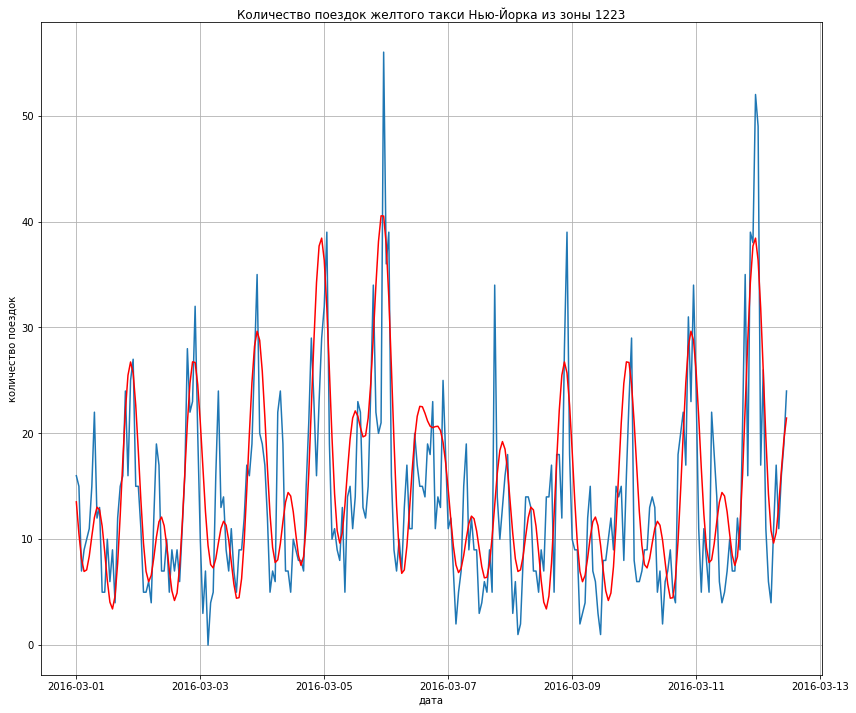

In [118]:

plt.figure(figsize=(14,12))
plt.grid(True)
plt.title(u'Количество поездок желтого такси Нью-Йорка из зоны 1223')
plt.xlabel(u'дата')
plt.ylabel(u'количество поездок')
plt.plot(raw_data[0].head(int(round(raw_data.shape[0] / 8))).index , raw_data[0].head(int(round(raw_data.shape[0] / 8))).values)
plt.plot(raw_data[0].head(int(round(raw_data.shape[0] / 8))).index , data15['predictions'].head(int(round(raw_data.shape[0] / 8))).values, color='r');

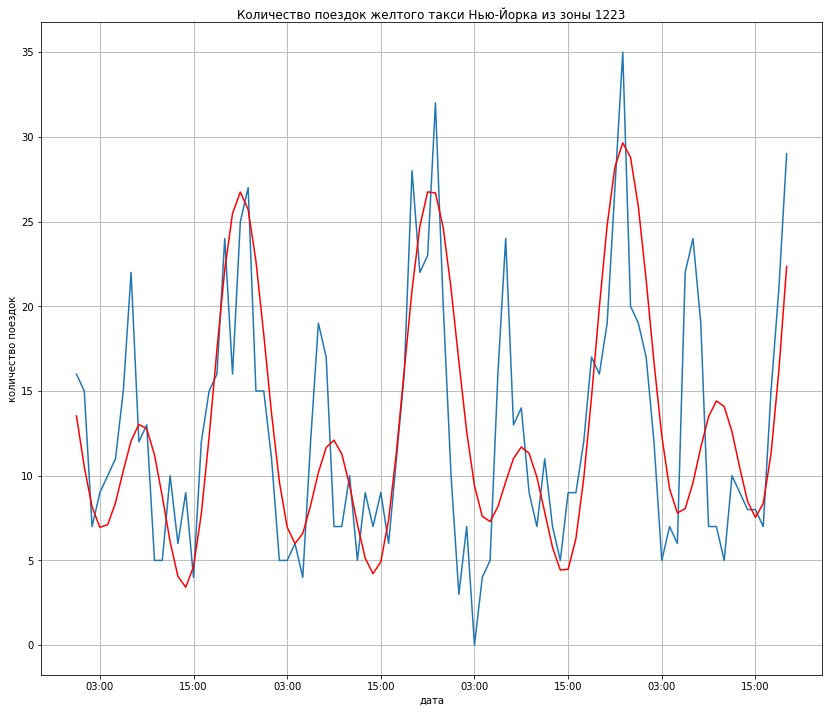

In [119]:

plt.figure(figsize=(14,12))
plt.grid(True)
plt.title(u'Количество поездок желтого такси Нью-Йорка из зоны 1223')
plt.xlabel(u'дата')
plt.ylabel(u'количество поездок')
plt.plot(raw_data[0].head(int(round(raw_data.shape[0] / 24))).index , raw_data[0].head(int(round(raw_data.shape[0] / 24))).values)
plt.plot(raw_data[0].head(int(round(raw_data.shape[0] / 24))).index , data15['predictions'].head(int(round(raw_data.shape[0] / 24))).values, color='r');

Визуально качество вполне неплохое.

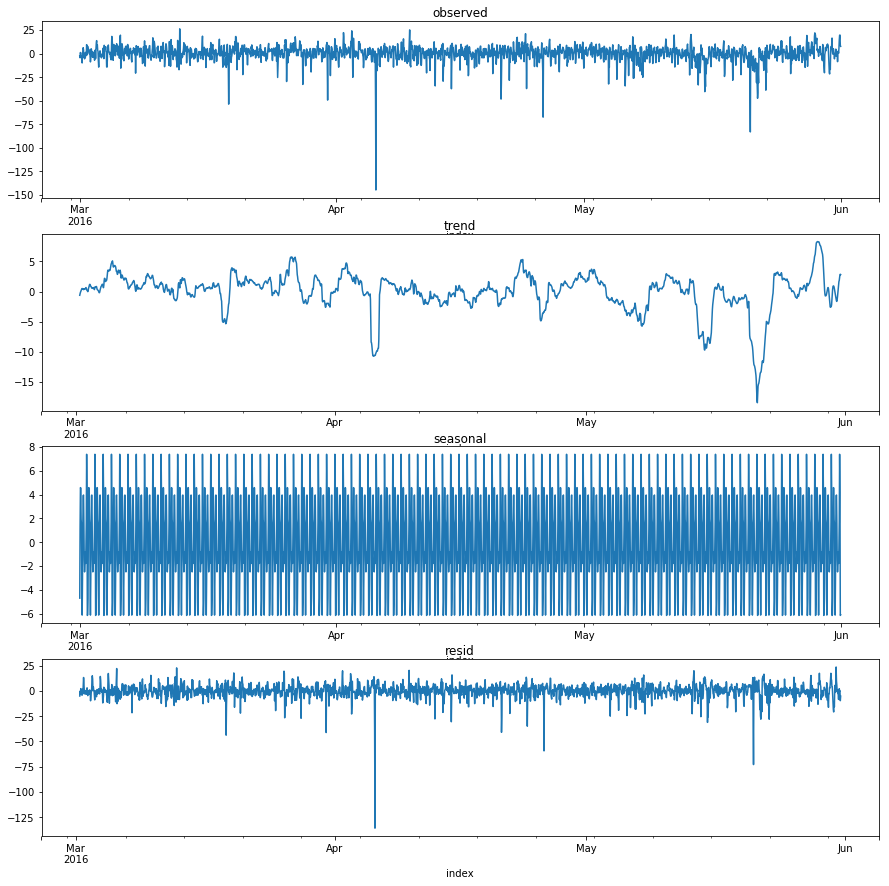

In [120]:
# Проанализируем остатки:
raw_data['remains'] = data15['predictions'].values - raw_data[0].values

res = sm.tsa.seasonal_decompose(raw_data['remains'].head(int(round(raw_data.shape[0]))))
fig, (ax4, ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,15))
res.observed.plot(ax=ax4, title='observed')
res.trend.plot(ax=ax1, title='trend')
res.seasonal.plot(ax=ax2, title='seasonal')
res.resid.plot(ax=ax3, title='resid');

Какой-то явной закономерности в остатках не наблюдается

# 3 Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.

Дифференцирование  по неделям

In [121]:

raw_data['shift_1'] =  raw_data['remains'] - raw_data['remains'].shift(168)

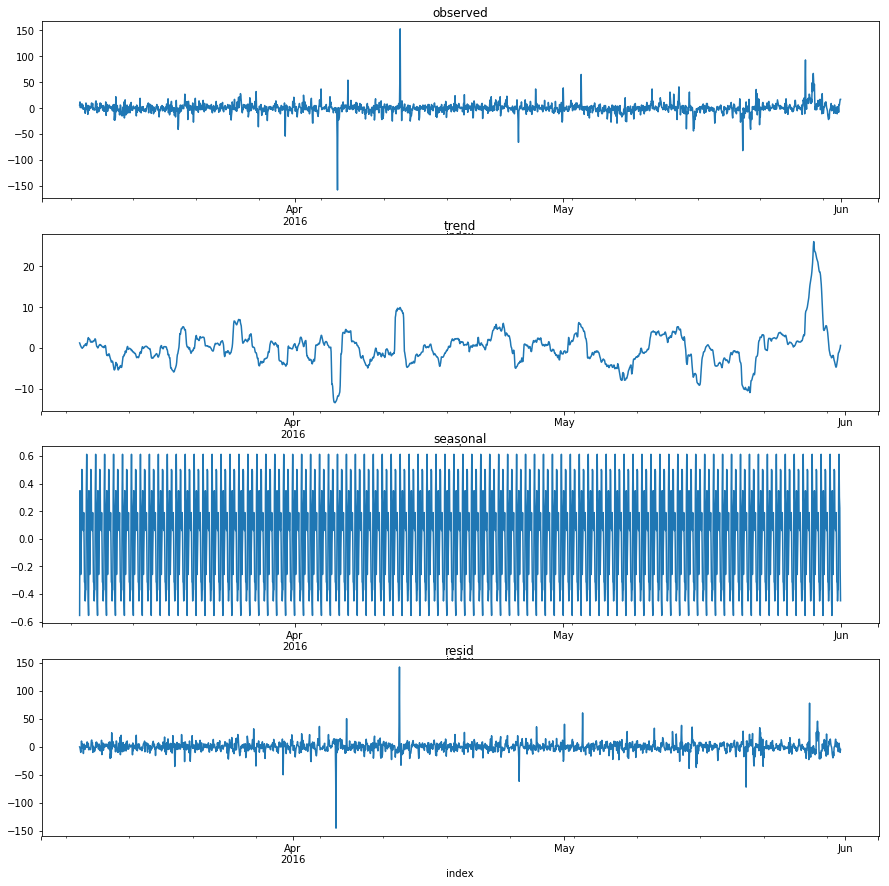

In [122]:
res = sm.tsa.seasonal_decompose(raw_data['shift_1'].dropna())
fig, (ax4, ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,15))
res.observed.plot(ax=ax4, title='observed')
res.trend.plot(ax=ax1, title='trend')
res.seasonal.plot(ax=ax2, title='seasonal')
res.resid.plot(ax=ax3, title='resid');

Применим дифференцирование по суткам
:

In [123]:
raw_data['shift_2'] =  raw_data['shift_1'] - raw_data['shift_1'].shift(24)

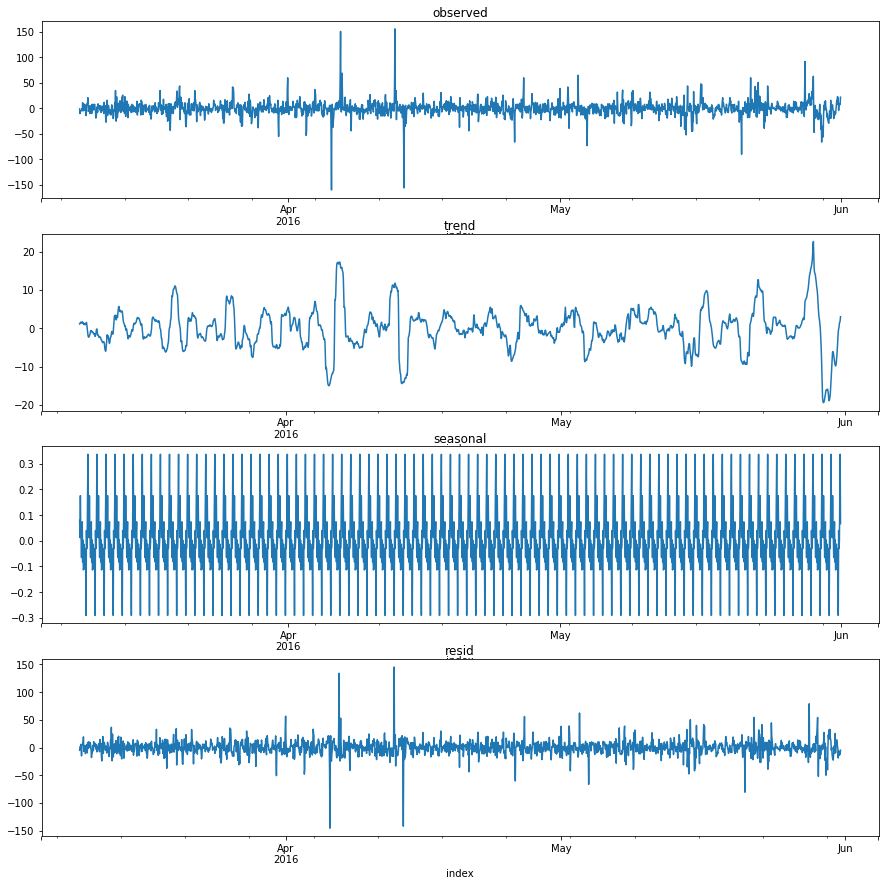

In [124]:
res = sm.tsa.seasonal_decompose(raw_data['shift_2'].dropna())
fig, (ax4, ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,15))
res.observed.plot(ax=ax4, title='observed')
res.trend.plot(ax=ax1, title='trend')
res.seasonal.plot(ax=ax2, title='seasonal')
res.resid.plot(ax=ax3, title='resid');

# 4 Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров p, q, P, Qp,q,P,Q. Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.

Посмотрим на ACF полученного ряда (сначала за неделю, потом посуточно):

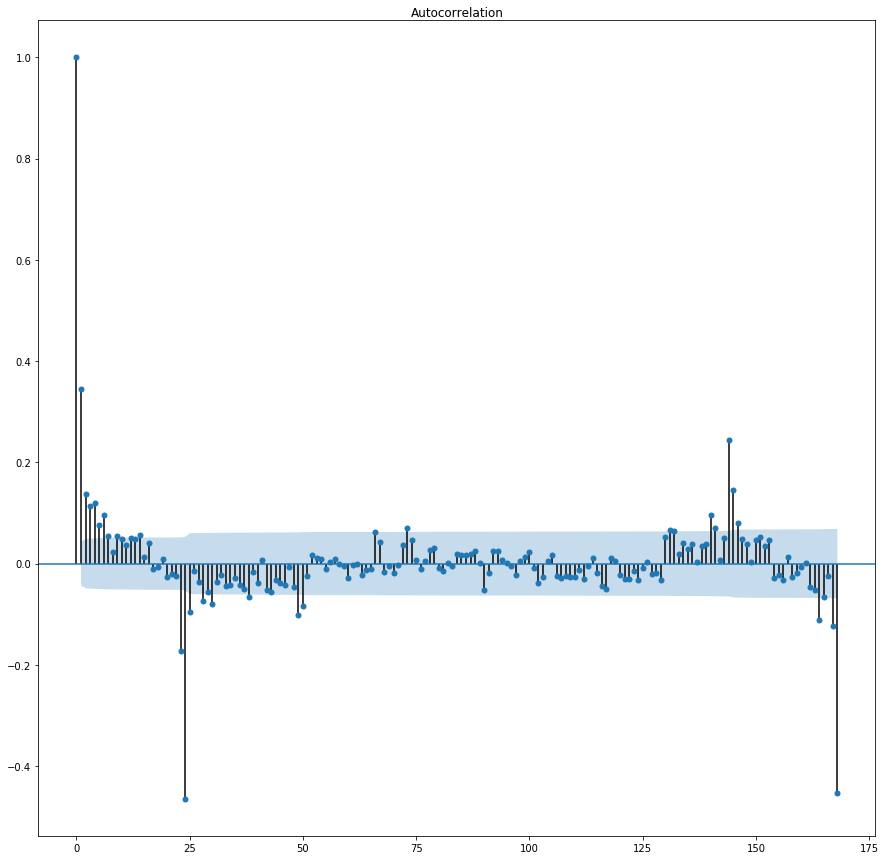

In [125]:
fig, ax4 = plt.subplots(1,1, figsize=(15,15))
sm.graphics.tsa.plot_acf(raw_data['shift_2'].dropna(),lags=168,  ax=ax4);


q - максимальный значимый несезонный лаг.
Возьмем 4
q = 4

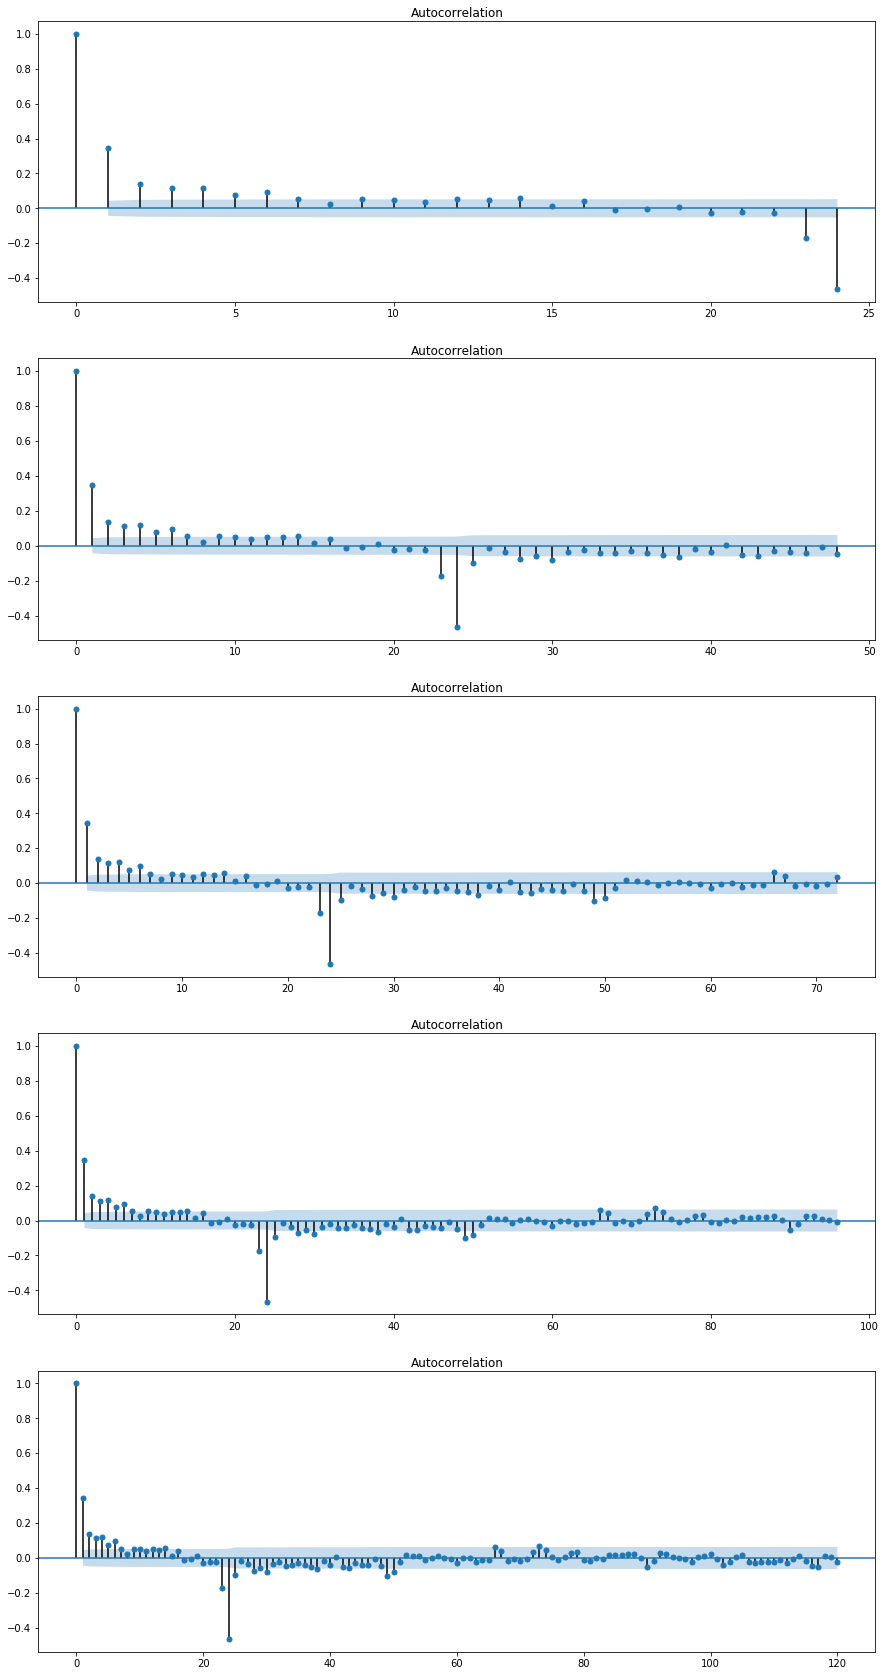

In [126]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(15,30))
sm.graphics.tsa.plot_acf(raw_data['shift_2'].dropna(),lags=24,  ax=ax1)
sm.graphics.tsa.plot_acf(raw_data['shift_2'].dropna(),lags=24*2,  ax=ax2)
sm.graphics.tsa.plot_acf(raw_data['shift_2'].dropna(),lags=24*3,  ax=ax3)
sm.graphics.tsa.plot_acf(raw_data['shift_2'].dropna(),lags=24*4,  ax=ax4)
sm.graphics.tsa.plot_acf(raw_data['shift_2'].dropna(),lags=24*5,  ax=ax5);

Q - максимальный значимый сезонный лаг, деленный на значение периода S;
Из сезонных лагов значим только 24, поэтому Q = 1
q=1,2,3,4

Посмотрим на PACF полученного ряда:

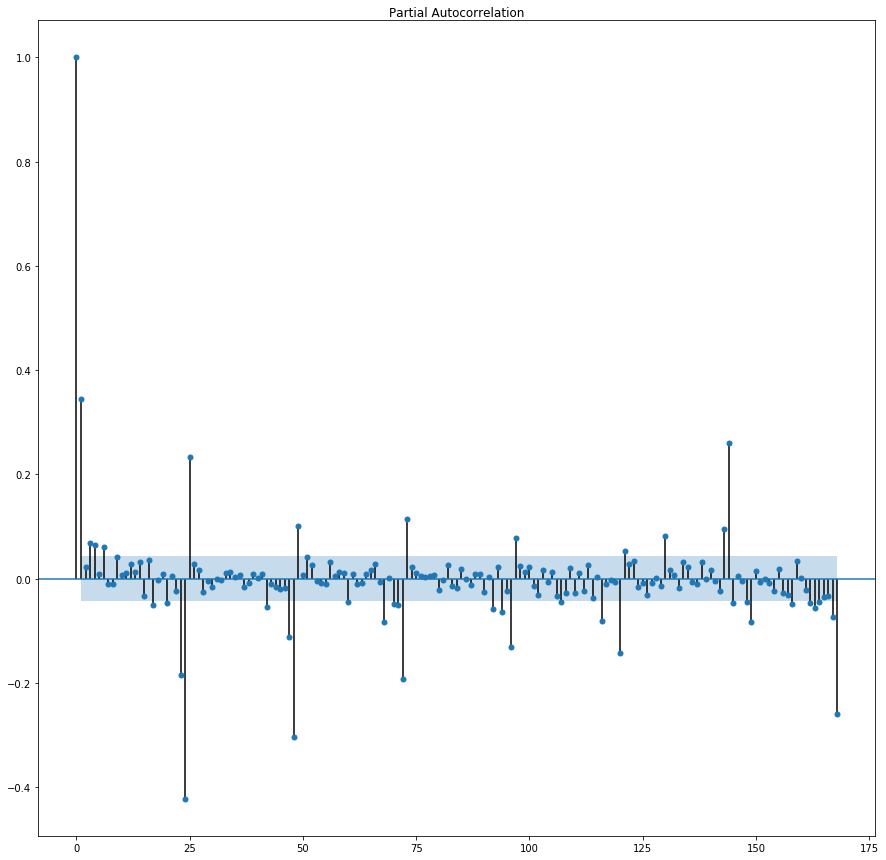

In [127]:
fig, ax4 = plt.subplots(1,1, figsize=(15,15))
sm.graphics.tsa.plot_pacf(raw_data['shift_2'].dropna(),lags=168,  ax=ax4);

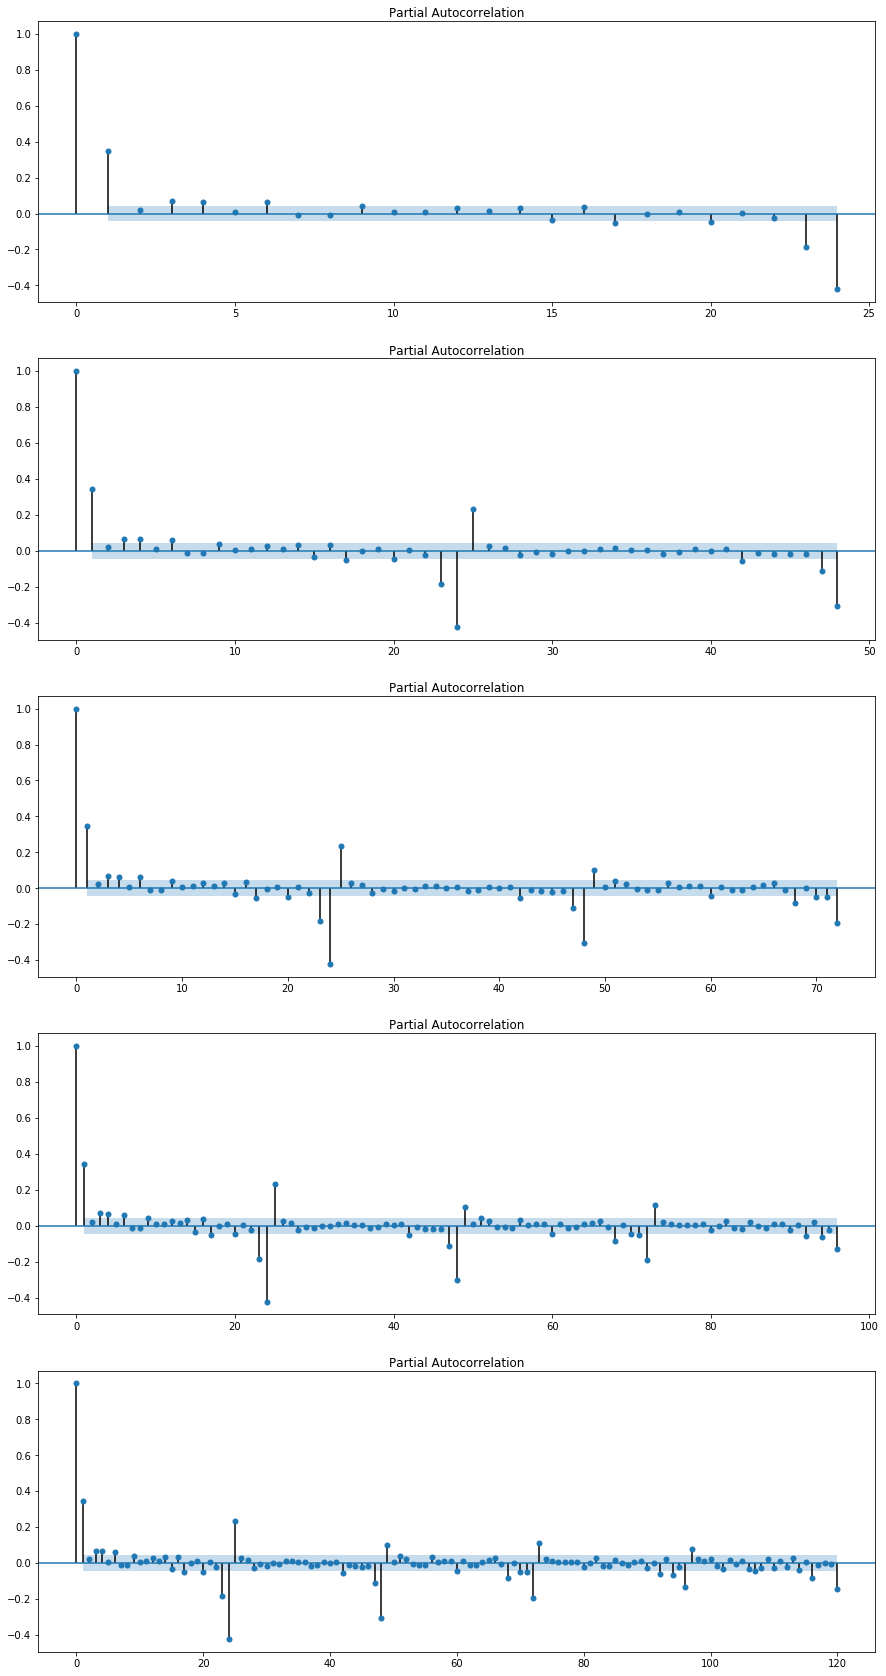

In [128]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(15,30))
sm.graphics.tsa.plot_pacf(raw_data['shift_2'].dropna(),lags=24,  ax=ax1)
sm.graphics.tsa.plot_pacf(raw_data['shift_2'].dropna(),lags=24*2,  ax=ax2)
sm.graphics.tsa.plot_pacf(raw_data['shift_2'].dropna(),lags=24*3,  ax=ax3)
sm.graphics.tsa.plot_pacf(raw_data['shift_2'].dropna(),lags=24*4,  ax=ax4)
sm.graphics.tsa.plot_pacf(raw_data['shift_2'].dropna(),lags=24*5,  ax=ax5);

По графику Частичной Автокорреляции подберем значения P и p:

P - максимальный значимый сезонный лаг, деленный на значение периода S;
p - максимальный значимый несезонный лаг.
P = 5
p = 1 - наиболее значимый, кроме 0

Чтобы не затягиватьобучение аримы, возмем не все лаги от 0, а только значимые

In [129]:
ps = [0,1]
d=1
qs = [0,1,2,3,4]
Ps = [0,1,2,3,4,5]
D=1
Qs = range(1)

In [130]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [60]:
%%time # Единственный вариант, когда получилось обучить модель - вот. обучались не на исходных данных, а на дифференцированных остатках.
        # Потом к ним просто добавим предсказания регрессии.
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
a=0
for param in parameters_list:
    a+=1
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(raw_data['shift_2'].dropna(), order=(param[0], d, param[1]), initialization='approximate_diffuse',#
                                        #exog=data10,
                                        seasonal_order=(param[2], D, param[3], 24 )).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    print 'model # ', a,  ' processed'
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

model #  1  processed
model #  2  processed
model #  3  processed
model #  4  processed
model #  5  processed
model #  6  processed
model #  7  processed
model #  8  processed
model #  9  processed
model #  10  processed
model #  11  processed
model #  12  processed
model #  13  processed
model #  14  processed
model #  15  processed
model #  16  processed
model #  17  processed
model #  18  processed
model #  19  processed
model #  20  processed
model #  21  processed
model #  22  processed
model #  23  processed
model #  24  processed
model #  25  processed
model #  26  processed
model #  27  processed
model #  28  processed
model #  29  processed
model #  30  processed
model #  31  processed
model #  32  processed
model #  33  processed
model #  34  processed
model #  35  processed
model #  36  processed
model #  37  processed
model #  38  processed
model #  39  processed
model #  40  processed
model #  41  processed
model #  42  processed
model #  43  processed
model #  44  process

In [61]:
# 3 с лишним часа! и это попытки с пятой, до этого все висло. а я еще пытался за 2 года ее обучить! посмотрим, что за модель вышла у нас:

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

print(best_model.summary())

      parameters           aic
41  (1, 1, 5, 0)  16345.104271
47  (1, 2, 5, 0)  16345.250895
29  (0, 4, 5, 0)  16346.239568
23  (0, 3, 5, 0)  16347.591071
53  (1, 3, 5, 0)  16359.176068
                                 Statespace Model Results                                 
Dep. Variable:                            shift_2   No. Observations:                 2016
Model:             SARIMAX(1, 1, 1)x(5, 1, 0, 24)   Log Likelihood               -8164.552
Date:                            Fri, 23 Aug 2019   AIC                          16345.104
Time:                                    18:42:03   BIC                          16389.875
Sample:                                03-09-2016   HQIC                         16361.547
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------

# 5 Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов KK или поменять порядки дифференцирования.

In [62]:
best_model.save('arima.pkl') # сохраняем на жесткий диск, чтобы в будущем не повторять обучение с нуля. весит она почти 4 гб

In [71]:
from statsmodels.tsa.arima_model import ARIMAResults # Выгружаем с жесткого диска
best_model = ARIMAResults.load('arima.pkl')


In [72]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            shift_2   No. Observations:                 2016
Model:             SARIMAX(1, 1, 1)x(5, 1, 0, 24)   Log Likelihood               -8164.552
Date:                            Sat, 24 Aug 2019   AIC                          16345.104
Time:                                    11:26:09   BIC                          16389.875
Sample:                                03-09-2016   HQIC                         16361.547
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3303      0.015     22.231      0.000       0.301       0.359
ma.L1         -0.9604      0.007   

In [74]:
print type(best_model.fittedvalues)

<class 'pandas.core.series.Series'>


In [93]:
raw_data['model'] = best_model.fittedvalues
raw_data['regression'] = data15['predictions'].values
raw_data['predict'] = raw_data['regression'] - raw_data['model']

In [94]:
print raw_data.head()

                        0  holiday   remains  shift_1  shift_2  model  \
index                                                                   
2016-03-01 00:00:00  16.0    False -2.469041      NaN      NaN    NaN   
2016-03-01 01:00:00  15.0    False -4.472155      NaN      NaN    NaN   
2016-03-01 02:00:00   7.0    False  1.159377      NaN      NaN    NaN   
2016-03-01 03:00:00   9.0    False -2.042307      NaN      NaN    NaN   
2016-03-01 04:00:00  10.0    False -2.892214      NaN      NaN    NaN   

                     regression  predict  
index                                     
2016-03-01 00:00:00   13.530959      NaN  
2016-03-01 01:00:00   10.527845      NaN  
2016-03-01 02:00:00    8.159377      NaN  
2016-03-01 03:00:00    6.957693      NaN  
2016-03-01 04:00:00    7.107786      NaN  


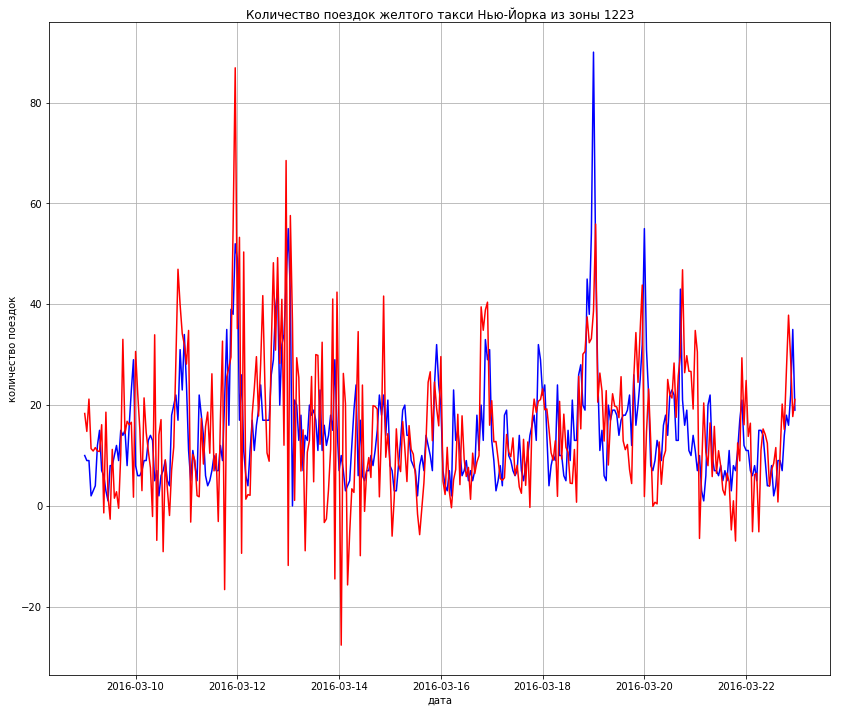

In [96]:

plt.figure(figsize=(14,12))
plt.grid(True)
plt.title(u'Количество поездок желтого такси Нью-Йорка из зоны 1223')
plt.xlabel(u'дата')
plt.ylabel(u'количество поездок')
plt.plot(raw_data[0].loc[raw_data['model'].dropna().index].head(168*2).index , raw_data[0].loc[raw_data['model'].dropna().index].head(168*2).values, color='b')
plt.plot(raw_data['predict'].loc[raw_data['model'].dropna().index].head(168*2).index , raw_data['predict'].loc[raw_data['model'].dropna().index].head(168*2).values, color='r');


Визуально что-то похожее. Гармоник стало побольше, чем в регрессии. C 12 по 16 марта дисперсия результатов наших предсказаний больше, чем в данных. В остальное время примерно похожа на оригинал. Давайте посмотрим на единственный выходной день в нашем периоде - День поминовения , 30 мая 2016.

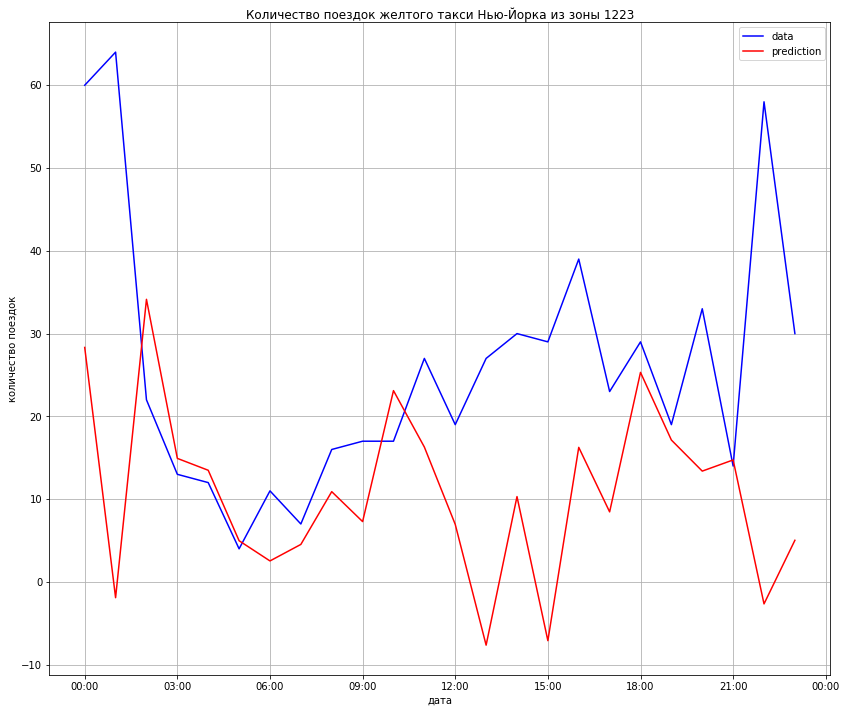

In [131]:
# datetime.date(2016, 5, 30)
plt.figure(figsize=(14,12))
plt.grid(True)
plt.title(u'Количество поездок желтого такси Нью-Йорка из зоны 1223')
plt.xlabel(u'дата')
plt.ylabel(u'количество поездок')

plt.plot(raw_data[0].loc[raw_data['model'].dropna().index.date == datetime.date(2016, 5, 30)].head(168*2).index , raw_data[0].loc[raw_data['model'].dropna().index.date == datetime.date(2016, 5, 30)].head(168*2).values, color='b', label='data')
plt.plot(raw_data['predict'].loc[raw_data['model'].dropna().index.date == datetime.date(2016, 5, 30)].head(168*2).index , raw_data['predict'].loc[raw_data['model'].dropna().index.date == datetime.date(2016, 5, 30)].head(168*2).values, color='r', label='prediction');
plt.legend();

Ну, не очень. В начале и конце дня еще похоже, но в середине совсем непохоже.

# 6 Проанализируйте качество построенной модели. Опишите, в какие периоды она плохо описывает данные? Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.

Посмотрим в общем на остатки:

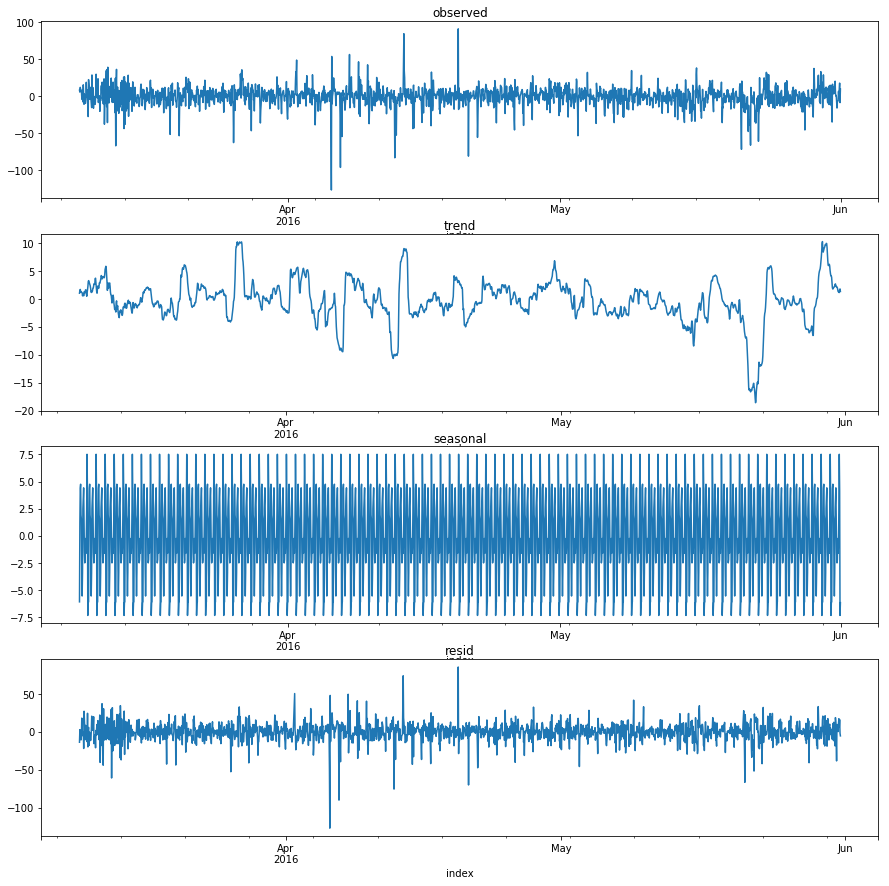

In [112]:
res = sm.tsa.seasonal_decompose((raw_data['predict'] - raw_data[0]).dropna())
fig, (ax4, ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,15))
res.observed.plot(ax=ax4, title='observed')
res.trend.plot(ax=ax1, title='trend')
res.seasonal.plot(ax=ax2, title='seasonal')
res.resid.plot(ax=ax3, title='resid');

А если бы мы не использовали ARIMA?

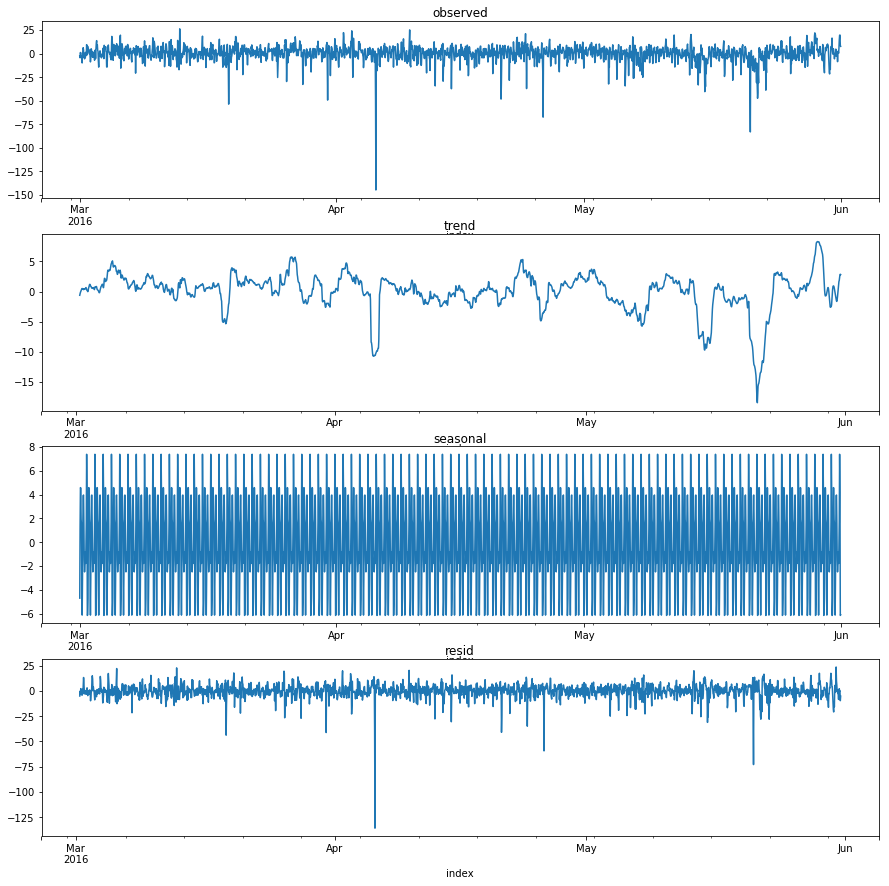

In [113]:
res = sm.tsa.seasonal_decompose((raw_data['regression'] - raw_data[0]).dropna())
fig, (ax4, ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,15))
res.observed.plot(ax=ax4, title='observed')
res.trend.plot(ax=ax1, title='trend')
res.seasonal.plot(ax=ax2, title='seasonal')
res.resid.plot(ax=ax3, title='resid');

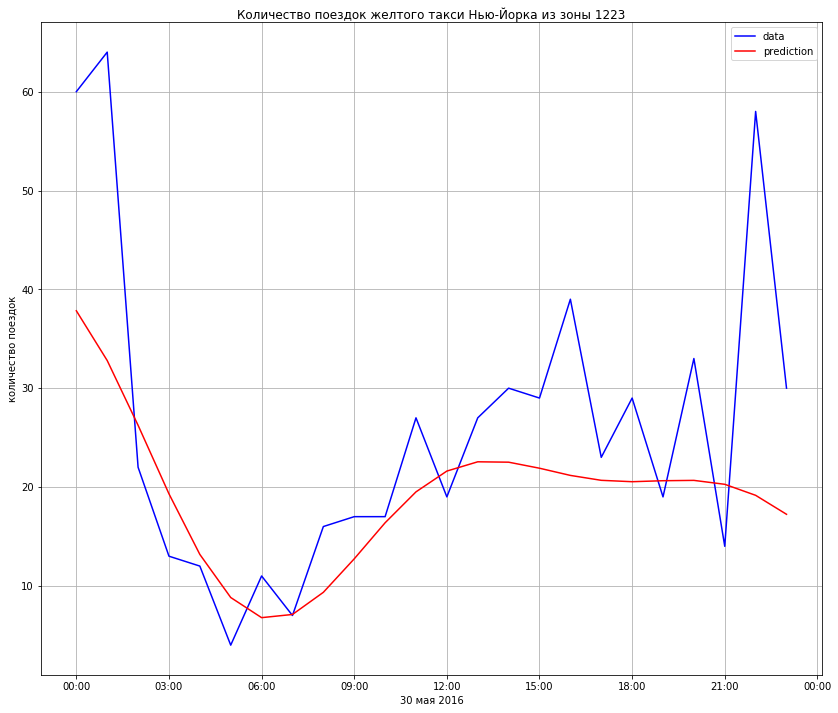

In [119]:
# datetime.date(2016, 5, 30)
plt.figure(figsize=(14,12))
plt.grid(True)
plt.title(u'Количество поездок желтого такси Нью-Йорка из зоны 1223')
plt.xlabel(u'30 мая 2016')
plt.ylabel(u'количество поездок')

plt.plot(raw_data[0].loc[raw_data['model'].dropna().index.date == datetime.date(2016, 5, 30)].head(168*2).index , raw_data[0].loc[raw_data['model'].dropna().index.date == datetime.date(2016, 5, 30)].head(168*2).values, color='b', label='data')
plt.plot(raw_data['regression'].loc[raw_data['model'].dropna().index.date == datetime.date(2016, 5, 30)].head(168*2).index , raw_data['regression'].loc[raw_data['model'].dropna().index.date == datetime.date(2016, 5, 30)].head(168*2).values, color='r', label='prediction');
plt.legend();

Визуально даже лучше

In [132]:
# А что, если еще больше увеличить количество признаков регрессии
data25 = ci_si(raw_data[0], 25)
data25= pd.concat([data25, pd.Series(raw_data.holiday.values)], axis=1, ignore_index=True)
print data25.head()
print data25.shape

         0         1         2         3         4         5         6   \
0  0.037391  0.999301  0.074730  0.997204  0.111964  0.993712  0.149042   
1  0.074730  0.997204  0.149042  0.988831  0.222521  0.974928  0.294755   
2  0.111964  0.993712  0.222521  0.974928  0.330279  0.943883  0.433884   
3  0.149042  0.988831  0.294755  0.955573  0.433884  0.900969  0.563320   
4  0.185912  0.982566  0.365341  0.930874  0.532032  0.846724  0.680173   

         7         8         9   ...              41        42        43  \
0  0.988831  0.185912  0.982566  ...    7.071068e-01  0.733052  0.680173   
1  0.955573  0.365341  0.930874  ...    6.123234e-17  0.997204 -0.074730   
2  0.900969  0.532032  0.846724  ...   -7.071068e-01  0.623490 -0.781831   
3  0.826239  0.680173  0.733052  ...   -1.000000e+00 -0.149042 -0.988831   
4  0.733052  0.804598  0.593820  ...   -7.071068e-01 -0.826239 -0.563320   

         44        45        46        47        48        49     50  
0  0.757972  0.652287

In [133]:
data = data25.copy()
labels = raw_data[0]

# Обучим регрессию

regression = linear_model.LinearRegression()
regression.fit(data,labels)

# Получим предсказание с коэффициентами , выбранными регрессией
data25['predictions'] = regression.predict(data)

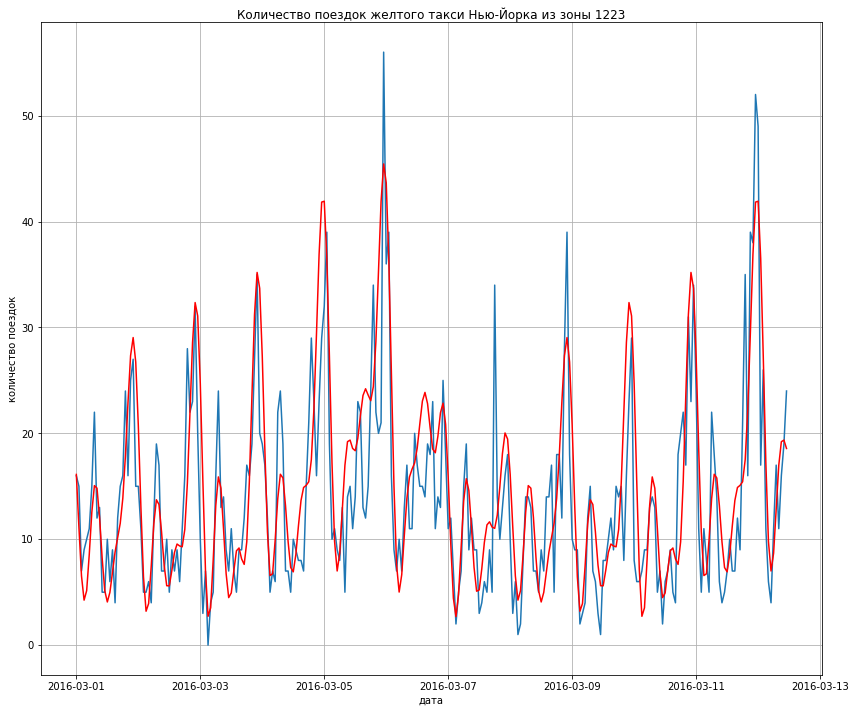

In [134]:

plt.figure(figsize=(14,12))
plt.grid(True)
plt.title(u'Количество поездок желтого такси Нью-Йорка из зоны 1223')
plt.xlabel(u'дата')
plt.ylabel(u'количество поездок')
plt.plot(raw_data[0].head(int(round(raw_data.shape[0] / 8))).index , raw_data[0].head(int(round(raw_data.shape[0] / 8))).values)
plt.plot(raw_data[0].head(int(round(raw_data.shape[0] / 8))).index , data25['predictions'].head(int(round(raw_data.shape[0] / 8))).values, color='r');

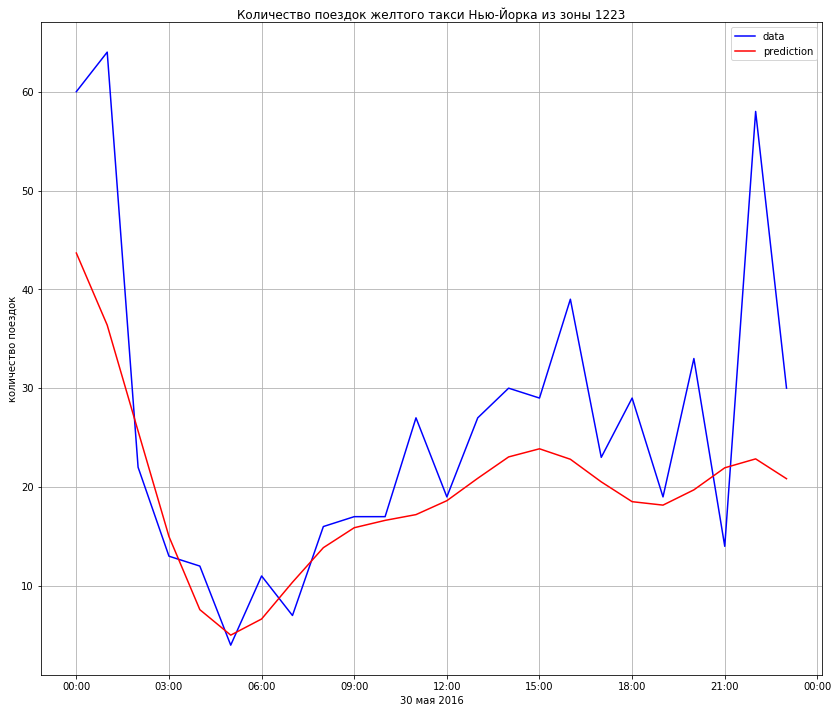

In [135]:
# datetime.date(2016, 5, 30)
raw_data['regression_25'] = data25['predictions'].values
plt.figure(figsize=(14,12))
plt.grid(True)
plt.title(u'Количество поездок желтого такси Нью-Йорка из зоны 1223')
plt.xlabel(u'30 мая 2016')
plt.ylabel(u'количество поездок')

plt.plot(raw_data[0].loc[raw_data['model'].dropna().index.date == datetime.date(2016, 5, 30)].head(168*2).index , raw_data[0].loc[raw_data['model'].dropna().index.date == datetime.date(2016, 5, 30)].head(168*2).values, color='b', label='data')
plt.plot(raw_data['regression_25'].loc[raw_data['model'].dropna().index.date == datetime.date(2016, 5, 30)].head(168*2).index , raw_data['regression_25'].loc[raw_data['model'].dropna().index.date == datetime.date(2016, 5, 30)].head(168*2).values, color='r', label='prediction');
plt.legend();

Почти то же самое, что и с 15 гармониками, увеличивать их смысла нет.

К сожалению, использование модели ARIMA только ухудшило результат моделирования регрессии. Последняя и так хорошо улавливает временные гармоники. В остатках большей частью остаются выбросы и случайный шум, которые информацию о следующих значениях не содержат (чего мы ожидаем от временного ряда). теперь добавим сюда то, что она обучается слишком долго и ресурсозатратно.

Попробуем уменьшить количество гармоник до первого варианта, 5. А суточными пусть занимается Арима.

In [37]:
data = data5.copy()
labels = raw_data[0]

# Обучим регрессию

regression = linear_model.LinearRegression()
regression.fit(data,labels)

# Получим предсказание с коэффициентами , выбранными регрессией
data5['predictions'] = regression.predict(data)

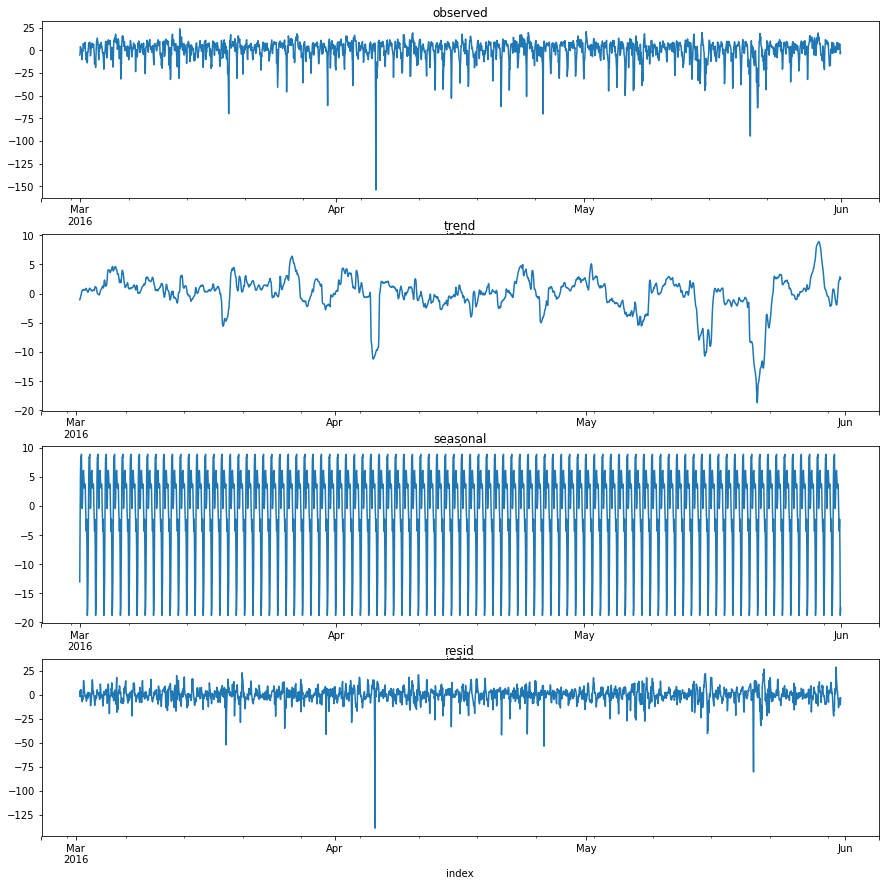

In [38]:
# Проанализируем остатки, тоже за месяц для наглядности:
raw_data['remains'] = data5['predictions'].values - raw_data[0].values

res = sm.tsa.seasonal_decompose(raw_data['remains'].head(int(round(raw_data.shape[0]))))
fig, (ax4, ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,15))
res.observed.plot(ax=ax4, title='observed')
res.trend.plot(ax=ax1, title='trend')
res.seasonal.plot(ax=ax2, title='seasonal')
res.resid.plot(ax=ax3, title='resid');

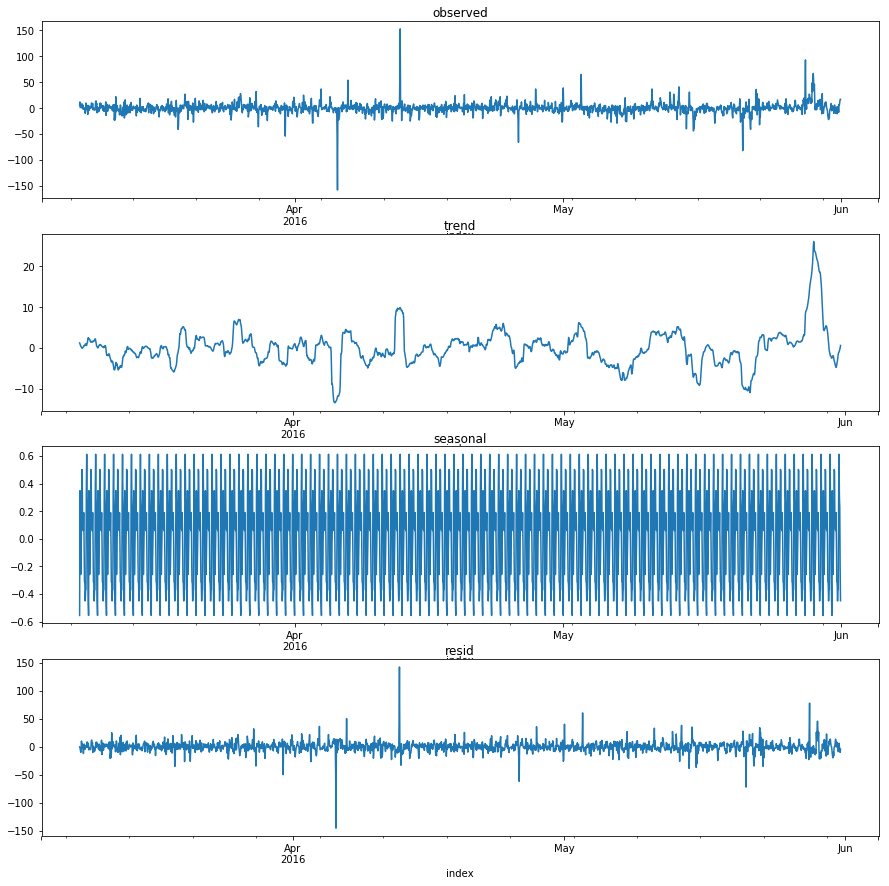

In [39]:
# Дифференцирование по неделям:
raw_data['shift_1'] =  raw_data['remains'] - raw_data['remains'].shift(168)
res = sm.tsa.seasonal_decompose(raw_data['shift_1'].dropna())
fig, (ax4, ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,15))
res.observed.plot(ax=ax4, title='observed')
res.trend.plot(ax=ax1, title='trend')
res.seasonal.plot(ax=ax2, title='seasonal')
res.resid.plot(ax=ax3, title='resid');

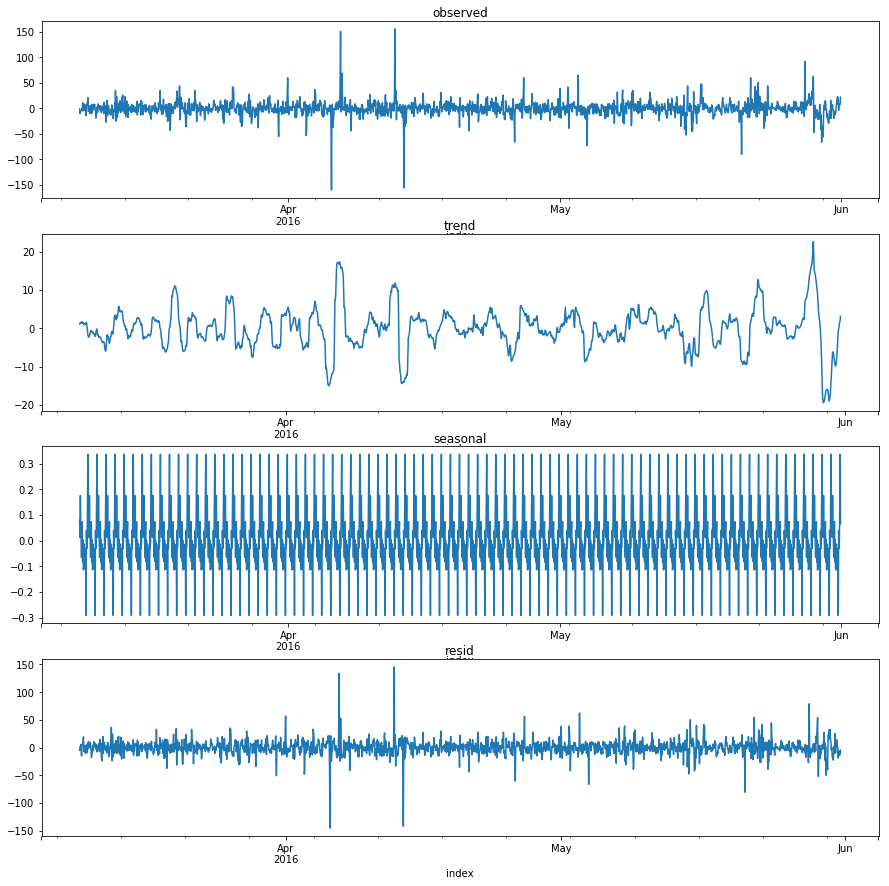

In [40]:
# Дифференцирование по суткам:
raw_data['shift_2'] =  raw_data['shift_1'].dropna() - raw_data['shift_1'].dropna().shift(24)
res = sm.tsa.seasonal_decompose(raw_data['shift_2'].dropna())
fig, (ax4, ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,15))
res.observed.plot(ax=ax4, title='observed')
res.trend.plot(ax=ax1, title='trend')
res.seasonal.plot(ax=ax2, title='seasonal')
res.resid.plot(ax=ax3, title='resid');

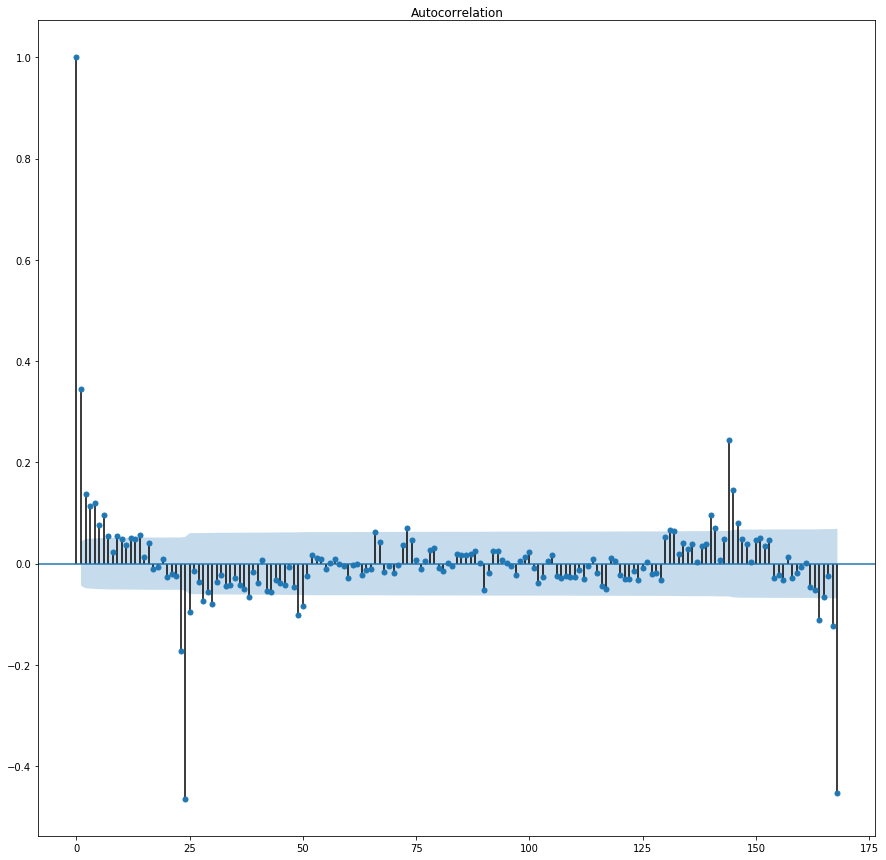

In [41]:
fig, ax4 = plt.subplots(1,1, figsize=(15,15))
sm.graphics.tsa.plot_acf(raw_data['shift_2'].dropna(),lags=168,  ax=ax4);


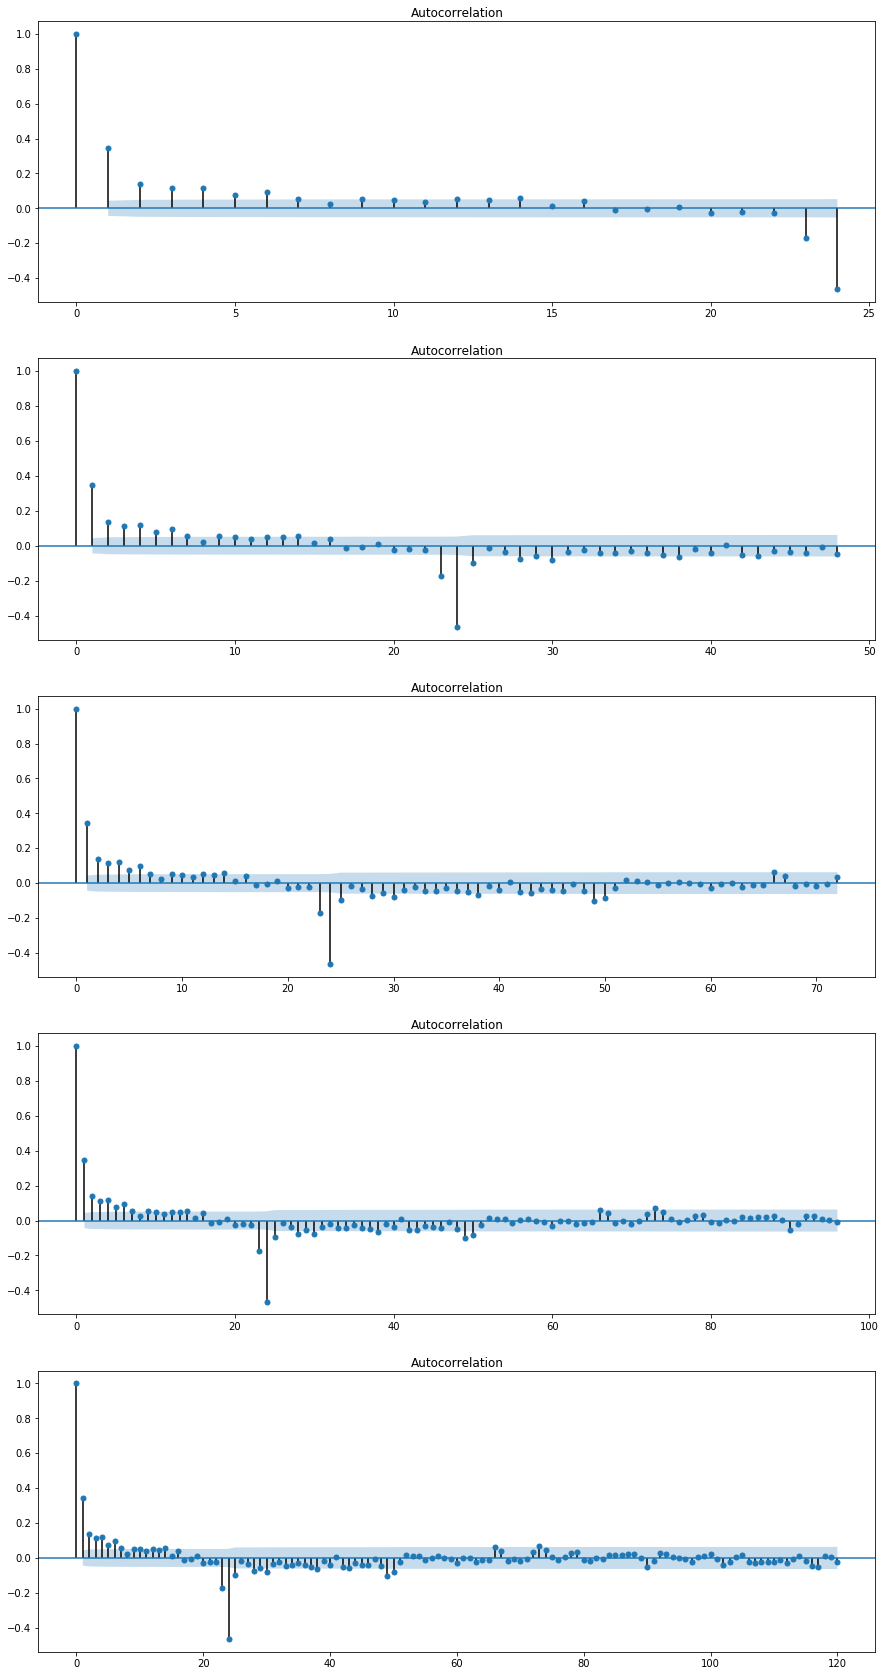

In [42]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(15,30))
sm.graphics.tsa.plot_acf(raw_data['shift_2'].dropna(),lags=24,  ax=ax1)
sm.graphics.tsa.plot_acf(raw_data['shift_2'].dropna(),lags=24*2,  ax=ax2)
sm.graphics.tsa.plot_acf(raw_data['shift_2'].dropna(),lags=24*3,  ax=ax3)
sm.graphics.tsa.plot_acf(raw_data['shift_2'].dropna(),lags=24*4,  ax=ax4)
sm.graphics.tsa.plot_acf(raw_data['shift_2'].dropna(),lags=24*5,  ax=ax5);

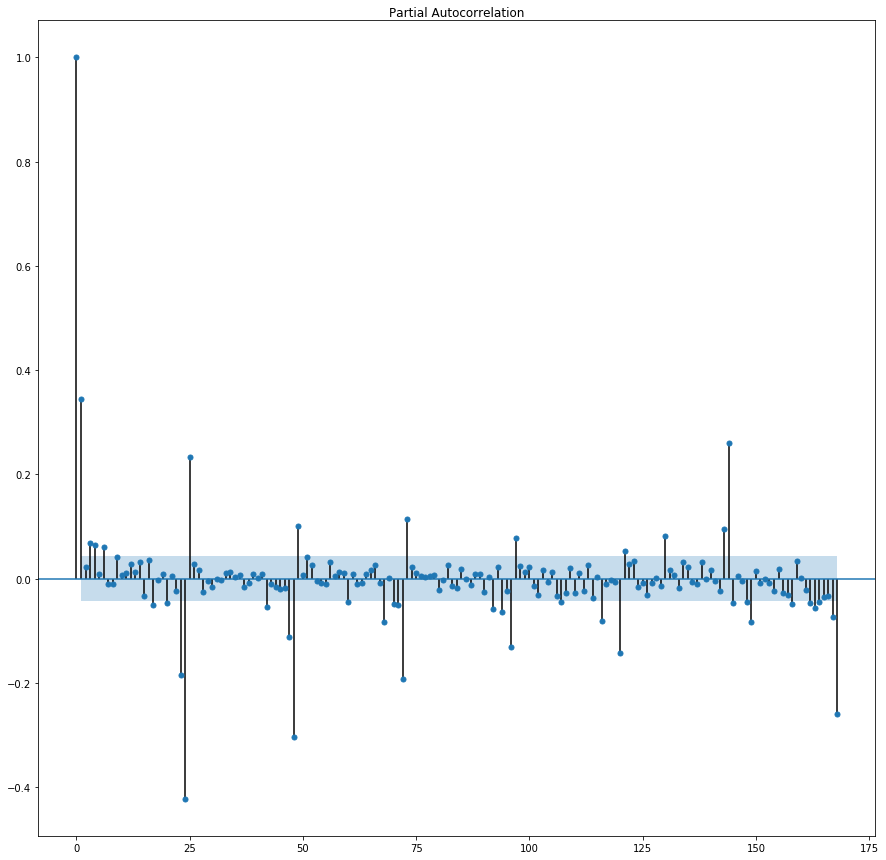

In [43]:
fig, ax4 = plt.subplots(1,1, figsize=(15,15))
sm.graphics.tsa.plot_pacf(raw_data['shift_2'].dropna(),lags=168,  ax=ax4);


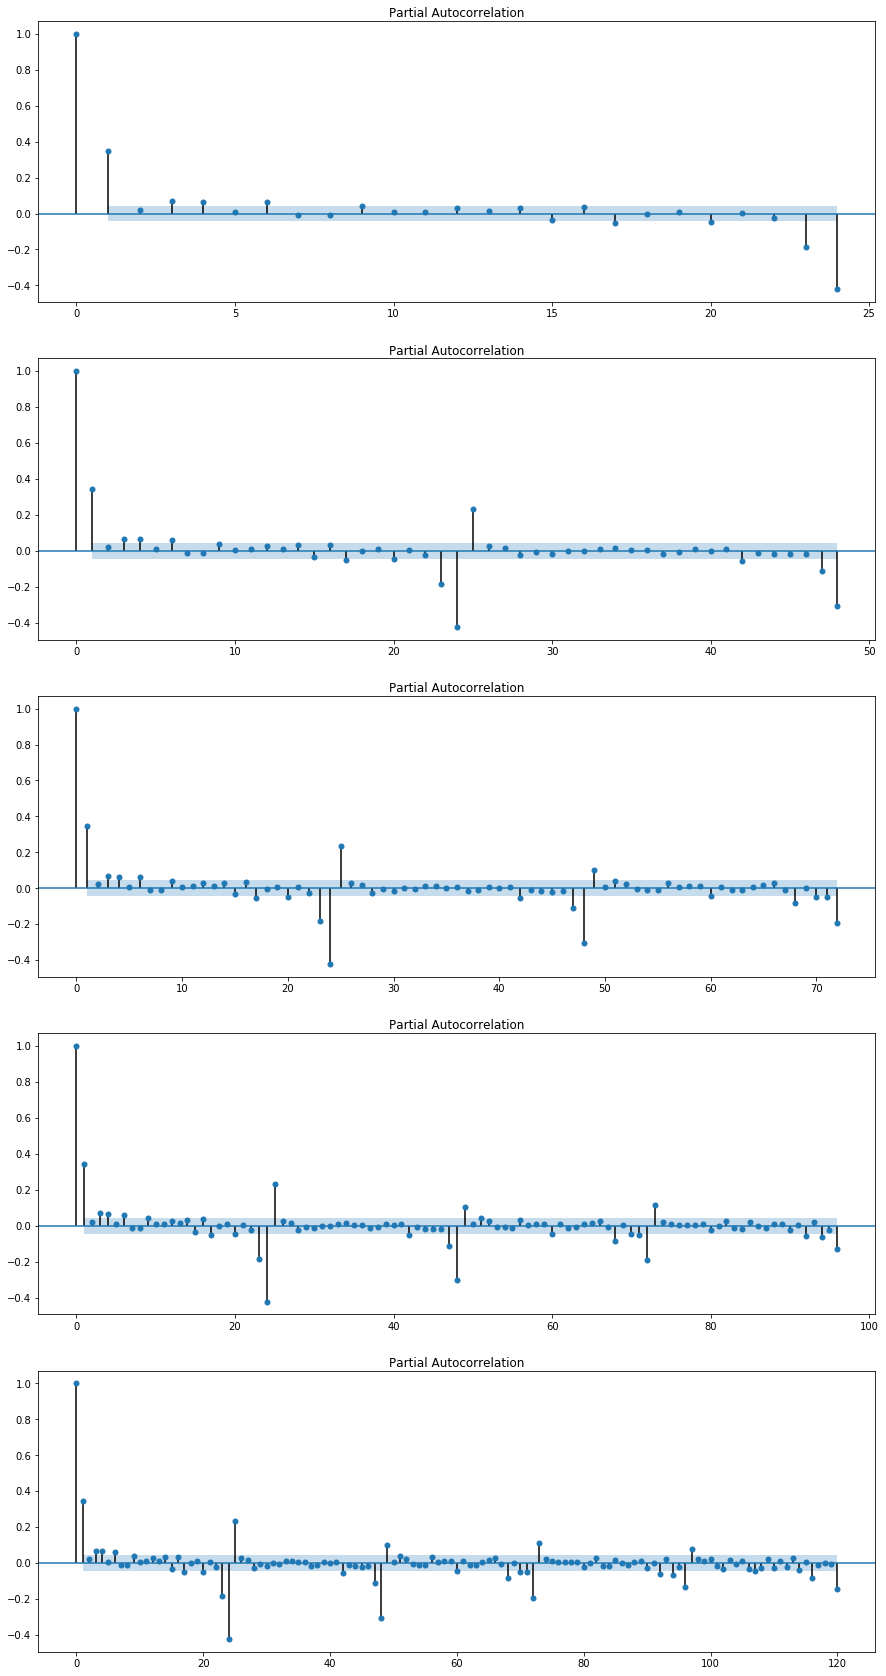

In [44]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(15,30))
sm.graphics.tsa.plot_pacf(raw_data['shift_2'].dropna(),lags=24,  ax=ax1)
sm.graphics.tsa.plot_pacf(raw_data['shift_2'].dropna(),lags=24*2,  ax=ax2)
sm.graphics.tsa.plot_pacf(raw_data['shift_2'].dropna(),lags=24*3,  ax=ax3)
sm.graphics.tsa.plot_pacf(raw_data['shift_2'].dropna(),lags=24*4,  ax=ax4)
sm.graphics.tsa.plot_pacf(raw_data['shift_2'].dropna(),lags=24*5,  ax=ax5);

In [45]:

d=1
Qs = range(1)
qs = [0,1]
Ps = [0,1,2,3,4,5]
ps = [0,1]
D=1

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

24

In [65]:
del best_model

In [46]:
%%time 
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
a=0
for param in parameters_list:
    a+=1
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(raw_data['shift_2'].dropna(), order=(param[0], d, param[1]), initialization='approximate_diffuse',#
                                        seasonal_order=(param[2], D, param[3], 24 )).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    print 'model # ', a,  ' processed; parameters: ', param
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

model #  1  processed; parameters:  (0, 0, 0, 0)
model #  2  processed; parameters:  (0, 0, 1, 0)
model #  3  processed; parameters:  (0, 0, 2, 0)
model #  4  processed; parameters:  (0, 0, 3, 0)
model #  5  processed; parameters:  (0, 0, 4, 0)
model #  6  processed; parameters:  (0, 0, 5, 0)
model #  7  processed; parameters:  (0, 1, 0, 0)
model #  8  processed; parameters:  (0, 1, 1, 0)
model #  9  processed; parameters:  (0, 1, 2, 0)
model #  10  processed; parameters:  (0, 1, 3, 0)
model #  11  processed; parameters:  (0, 1, 4, 0)
model #  12  processed; parameters:  (0, 1, 5, 0)
model #  13  processed; parameters:  (1, 0, 0, 0)
model #  14  processed; parameters:  (1, 0, 1, 0)
model #  15  processed; parameters:  (1, 0, 2, 0)
model #  16  processed; parameters:  (1, 0, 3, 0)
model #  17  processed; parameters:  (1, 0, 4, 0)
model #  18  processed; parameters:  (1, 0, 5, 0)
model #  19  processed; parameters:  (1, 1, 0, 0)
model #  20  processed; parameters:  (1, 1, 1, 0)
model #  

In [47]:
# с 3 попытки и урезания параметров она обучилась
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

print(best_model.summary())

      parameters           aic
23  (1, 1, 5, 0)  16345.217939
11  (0, 1, 5, 0)  16485.588855
22  (1, 1, 4, 0)  16743.144269
21  (1, 1, 3, 0)  16760.991108
17  (1, 0, 5, 0)  16785.561198
                                 Statespace Model Results                                 
Dep. Variable:                            shift_2   No. Observations:                 2016
Model:             SARIMAX(1, 1, 1)x(5, 1, 0, 24)   Log Likelihood               -8164.609
Date:                            Sun, 25 Aug 2019   AIC                          16345.218
Time:                                    10:10:46   BIC                          16389.989
Sample:                                03-09-2016   HQIC                         16361.661
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------

In [48]:
# data_noharm['predictions']
raw_data['model'] = best_model.fittedvalues
raw_data['regression'] = data5['predictions'].values
raw_data['predict'] = raw_data['regression'] - raw_data['model']

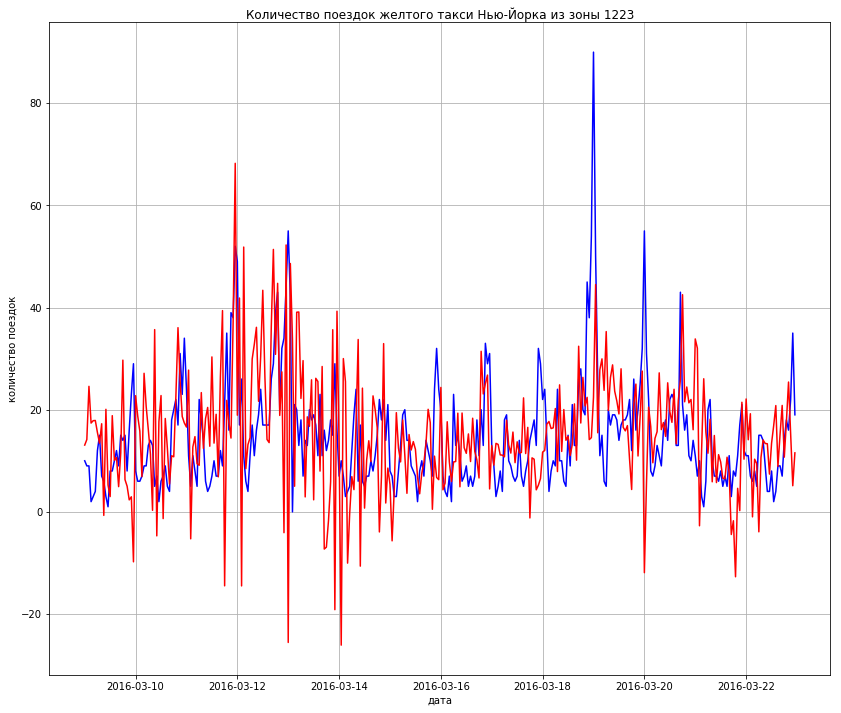

In [49]:

plt.figure(figsize=(14,12))
plt.grid(True)
plt.title(u'Количество поездок желтого такси Нью-Йорка из зоны 1223')
plt.xlabel(u'дата')
plt.ylabel(u'количество поездок')
plt.plot(raw_data[0].loc[raw_data['model'].dropna().index].head(168*2).index , raw_data[0].loc[raw_data['model'].dropna().index].head(168*2).values, color='b')
plt.plot(raw_data['predict'].loc[raw_data['model'].dropna().index].head(168*2).index , raw_data['predict'].loc[raw_data['model'].dropna().index].head(168*2).values, color='r');


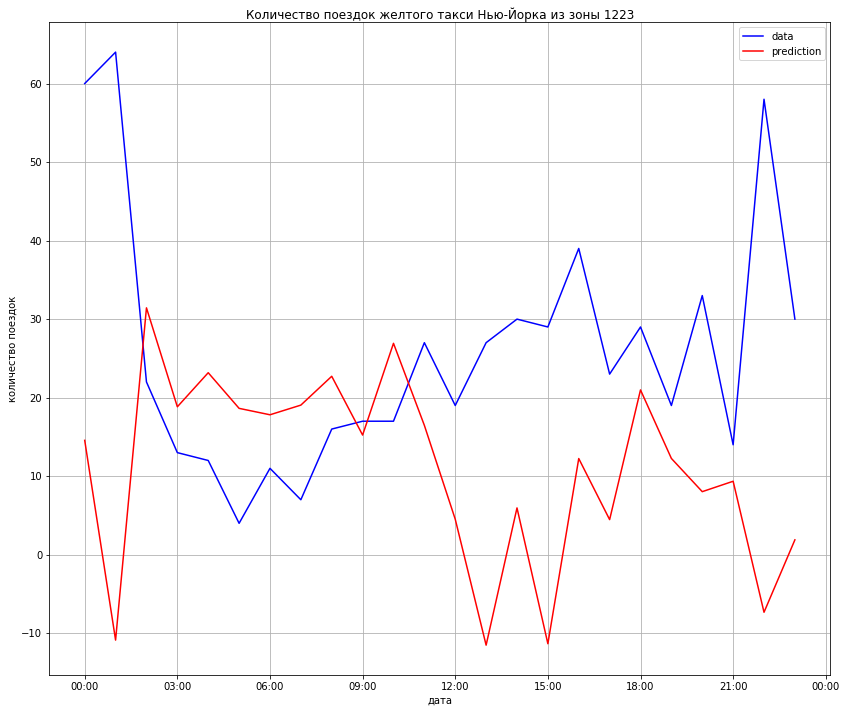

In [50]:
# datetime.date(2016, 5, 30)
plt.figure(figsize=(14,12))
plt.grid(True)
plt.title(u'Количество поездок желтого такси Нью-Йорка из зоны 1223')
plt.xlabel(u'дата')
plt.ylabel(u'количество поездок')

plt.plot(raw_data[0].loc[raw_data['model'].dropna().index.date == datetime.date(2016, 5, 30)].head(168*2).index , raw_data[0].loc[raw_data['model'].dropna().index.date == datetime.date(2016, 5, 30)].head(168*2).values, color='b', label='data')
plt.plot(raw_data['predict'].loc[raw_data['model'].dropna().index.date == datetime.date(2016, 5, 30)].head(168*2).index , raw_data['predict'].loc[raw_data['model'].dropna().index.date == datetime.date(2016, 5, 30)].head(168*2).values, color='r', label='prediction');
plt.legend();

Существенного улучшения не видно. Вернемся к предыдущей модели.

In [78]:
from statsmodels.tsa.arima_model import ARIMAResults # Выгружаем с жесткого диска
best_model = ARIMAResults.load('arima.pkl')
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            shift_2   No. Observations:                 2016
Model:             SARIMAX(1, 1, 1)x(5, 1, 0, 24)   Log Likelihood               -8164.552
Date:                            Sun, 25 Aug 2019   AIC                          16345.104
Time:                                    08:14:59   BIC                          16389.875
Sample:                                03-09-2016   HQIC                         16361.547
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3303      0.015     22.231      0.000       0.301       0.359
ma.L1         -0.9604      0.007   

In [79]:
raw_data['model'] = best_model.fittedvalues
raw_data['regression'] = data15['predictions'].values
raw_data['predict'] = raw_data['regression'] - raw_data['model']

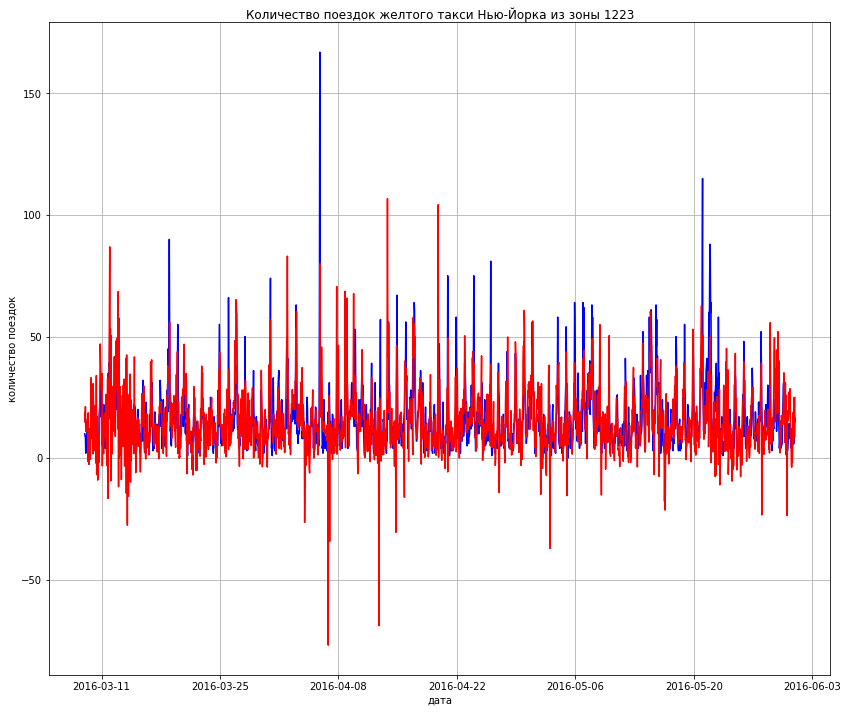

In [82]:

plt.figure(figsize=(14,12))
plt.grid(True)
plt.title(u'Количество поездок желтого такси Нью-Йорка из зоны 1223')
plt.xlabel(u'дата')
plt.ylabel(u'количество поездок')
plt.plot(raw_data[0].loc[raw_data['model'].dropna().index].index , raw_data[0].loc[raw_data['model'].dropna().index].values, color='b')
plt.plot(raw_data['predict'].loc[raw_data['model'].dropna().index].index , raw_data['predict'].loc[raw_data['model'].dropna().index].values, color='r');


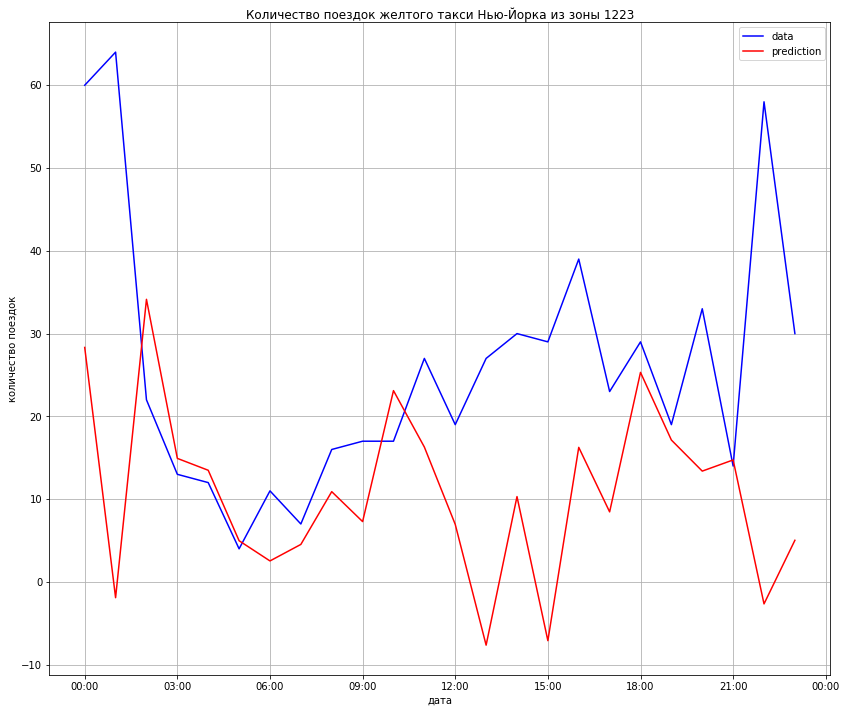

In [81]:
# datetime.date(2016, 5, 30)
plt.figure(figsize=(14,12))
plt.grid(True)
plt.title(u'Количество поездок желтого такси Нью-Йорка из зоны 1223')
plt.xlabel(u'дата')
plt.ylabel(u'количество поездок')

plt.plot(raw_data[0].loc[raw_data['model'].dropna().index.date == datetime.date(2016, 5, 30)].head(168*2).index , raw_data[0].loc[raw_data['model'].dropna().index.date == datetime.date(2016, 5, 30)].head(168*2).values, color='b', label='data')
plt.plot(raw_data['predict'].loc[raw_data['model'].dropna().index.date == datetime.date(2016, 5, 30)].head(168*2).index , raw_data['predict'].loc[raw_data['model'].dropna().index.date == datetime.date(2016, 5, 30)].head(168*2).values, color='r', label='prediction');
plt.legend();

Качество модели оставляет желать лучшего. Добавление ARIMA в регрессию с большим количеством признаков не оправдало себя ни по производительности, ни по результатам. Может быть, это из-за того, что мы взяли зону с относительно небольшим средним количеством поездок и, следовательно, большой долей случайного шума. Моодель плохо описывает данные в разные периоды, в одну неделю - в конце, в другую - в середине, в третью - хорошо описывает. Праздничный день описывается, по крайней мере регрессией, вполне удовлетворительно.